**NAME: PARTHA SAKHA PAUL**

**ROLL: MA23M016**

    CS6910_assignment1

In [125]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# importing dataset
from keras.datasets import fashion_mnist

# for the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns # omly for plotting the confusion matrix

# ***Question 1***

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

In [126]:
# loading the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# spliting data for validation
x_val = x_train[54000:]
y_val = y_train[54000:]
# print(x_val)
# print(y_val)
# spliting data for training
x_train = x_train[:54000]
y_train = y_train[:54000]
# print(x_train)
# print(y_train)

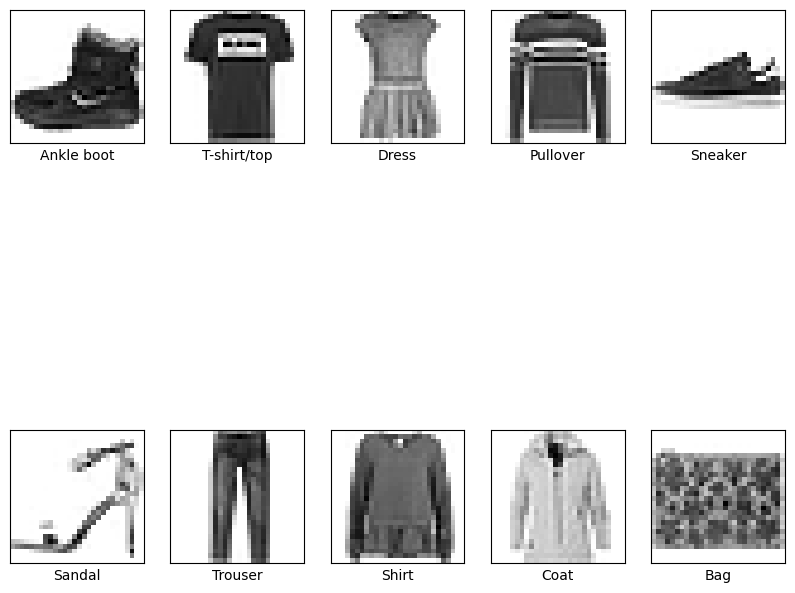

In [127]:
# labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
image = []
label = []
for i in range(54000):
  if len(label) >= 10:
    break;
  if class_names[y_train[i]] not in label:
      image.append(x_train[i])
      label.append(class_names[y_train[i]])

#the dimensions of the plot grid
plt.figure(figsize=(10,10))

for i in range(len(image)):
  plt.subplot(2, 5, i+1)  #plotting in a 2x5 grid
  plt.xticks([])  #remove x-ticks
  plt.yticks([])  #remove y-ticks
  plt.grid(False)  #no grid
  plt.imshow(image[i], cmap=plt.cm.binary)  #plotting the image in binary colormap
  plt.xlabel(label[i])  #x-axis label
plt.show()

In [128]:
# vectorise the data
x_train = x_train.reshape(x_train.shape[0], 784)
# print(x_train.shape)
x_val  = x_val.reshape(x_val.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# normalize
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val  = x_val / 255.0
# print(x_train)

# One hot encoding for labels
def one_hot_enc(labels, dimension=10):
    # Creating an array of zeros of shape (number of labels, number of categories)
    one_hot_labels = np.zeros((len(labels), dimension))

    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels
#ref : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html



# print(y_train[1023])
# one-hot encoding to the datasets
y_train_encode = one_hot_enc(y_train)
y_val_encode = one_hot_enc(y_val)
y_test_encode = one_hot_enc(y_test)

# print(y_train_encode[1023])  # for verifying
print(y_train_encode.shape) #verifying

(54000, 10)


In [129]:
#all necessary functions::
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid_deriv(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x <= 0, 0, 1)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x)**2

def cross_entropy(y_hat, y, sum_norm, regpara):
    m = y.shape[0]
    logyhat = np.log(y_hat)
    loss = -np.sum(y * logyhat) / m + regpara / 2 * sum_norm
    return loss

activation_functions = {
    "sigmoid": sigmoid,
    "relu": relu,
    "tanh": tanh
}

activation_derivatives = {
    "sigmoid": sigmoid_deriv,
    "relu": relu_deriv,
    "tanh": tanh_deriv
}
#ref : https://www.analyticsvidhya.com/blog/2021/04/activation-functions-and-their-derivatives-a-quick-complete-guide/

# ***Question 2***
    Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

    Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [130]:
class NeuralNetwork:
    #initialize the network with construtor
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)
        self.momenta_weights, self.momenta_biases = self.init_momenta_for_mgd()

    #initializing function
    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            # "xavier" weight_initialization
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            #random initialization
            else:
                stddev = 0.1  # standard deviation for random initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases

    #initializing momentums for mgd
    def init_momenta_for_mgd(self):
        momenta_weights = []
        momenta_biases = []
        for i in range(len(self.layer_sizes) - 1):
            v_weight = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            v_bias = np.zeros((1, self.layer_sizes[i + 1]))
            momenta_weights.append(v_weight)
            momenta_biases.append(v_bias)
        return momenta_weights, momenta_biases

    #forward propagation
    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

#ref:: https://medium.com/hackernoon/building-a-feedforward-neural-network-from-scratch-in-python-d3526457156b

In [131]:
layer_sizes = [784, 128, 10]

# initializing the model
model_forward = NeuralNetwork(layer_sizes, activation_func="sigmoid", weight_init="random")
_,_,y_hat = model_forward.feedforward(x_train)
print('A probability distribution over the 10 classes by feedforward NN before train:: \n',y_hat[5180])
# print(sum(y_hat[51]))
print('Corresponding labelled output:: \n',y_train_encode[5180])

A probability distribution over the 10 classes by feedforward NN before train:: 
 [0.23524944 0.02606007 0.09318564 0.0612025  0.11171473 0.15823738
 0.03622671 0.04570838 0.17648214 0.055933  ]
Corresponding labelled output:: 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# ***Question 3***
Implement the backpropagation algorithm with support for the following optimisation functions

    sgd
    momentum based gradient descent
    nesterov accelerated gradient descent
    rmsprop
    adam
    nadam

In [132]:
# for backward propagation and the optimizers
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad
    #ref:: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad

    #vanilla GD
    def vanilla_gd(self, grads, eta):
        # i = 0 to L-1; here len(self.weights) = L (as weights = [W1,W2,W3,...], list of weights W1,W2,W3,....)
        for i in range(len(self.weights)):
            self.weights[i] -= eta * grads["dW" + str(i + 1)]   #updating W1,W2,W3 by grad_descent rule
            self.biases[i] -= eta * grads["db" + str(i + 1)]    #updating b1,b2,b3 by grad_descent rule

    #SGD
    def sgd(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)
                # print(h['h0'])

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat, regpara)

                # Update weights and biases with SGD
                for i in range(1, len(self.layer_sizes)):
                    self.weights[i-1] -= eta * (grad["dW" + str(i)] + regpara * self.weights[i-1])
                    self.biases[i-1] -= eta * grad["db" + str(i)]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            # wandb.log({'train_loss': loss})
            # wandb.log({'train_accuracy': accuracy*100 })
            # wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            # wandb.log({'val_loss': val_loss})
            # wandb.log({'val_accuracy': val_accuracy*100 })

    #MGD
    def mgd(self,X_train, Y_train, X_val, Y_val_encode, max_epochs, eta, batch_size, regpara,beta=0.9):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat, regpara)

                # update with momentum
                for i in range(len(self.weights)):
                    # momentum updates
                    self.momenta_weights[i] = beta * self.momenta_weights[i] + eta * (grad["dW" + str(i + 1)] + regpara * self.weights[i])
                    self.momenta_biases[i] = beta * self.momenta_biases[i] + eta * grad["db" + str(i + 1)]

                    # update weights and biases
                    self.weights[i] -= self.momenta_weights[i] + eta * regpara * self.weights[i]
                    self.biases[i] -= self.momenta_biases[i]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            wandb.log({'train_loss': loss})
            wandb.log({'train_accuracy': accuracy*100 })
            wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            wandb.log({'val_loss': val_loss})
            wandb.log({'val_accuracy': val_accuracy*100 })

    #NAG
    def nag(self, X_train, Y_train, X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9):
        train_datapoints = X_train.shape[0]

        # initializing momenta for NAG
        prev_momenta_weights = [np.zeros_like(w) for w in self.weights]
        prev_momenta_biases = [np.zeros_like(b) for b in self.biases]

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # storing original weights and biases
                original_weights = [np.copy(w) for w in self.weights]
                original_biases = [np.copy(b) for b in self.biases]

                #  NAG method
                self.weights = [w - beta * v for w, v in zip(self.weights, prev_momenta_weights)]
                self.biases = [b - beta * v for b, v in zip(self.biases, prev_momenta_biases)]

                # Forward prop with lookahead weights and biases
                h, a, y_hat = self.feedforward(X_batch)

                # Backward prop
                grads = self.backward(h, a, Y_batch, y_hat, regpara)

                # Taking original weights and biases before actual update
                self.weights = original_weights
                self.biases = original_biases

                # Updating with computed grads and momentums
                for i in range(len(self.weights)):
                    momenta_weights = beta * prev_momenta_weights[i] + eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                    momenta_biases = beta * prev_momenta_biases[i] + eta * grads["db" + str(i + 1)]

                    self.weights[i] -= momenta_weights
                    self.biases[i] -= momenta_biases

                    # Updating momenta for next iteration
                    prev_momenta_weights[i] = momenta_weights
                    prev_momenta_biases[i] = momenta_biases

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            wandb.log({'train_loss': loss})
            wandb.log({'train_accuracy': accuracy*100 })
            wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            wandb.log({'val_loss': val_loss})
            wandb.log({'val_accuracy': val_accuracy*100 })

    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_loss': loss})
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_loss': val_loss})
          wandb.log({'val_accuracy': val_accuracy*100 })

    #ADAM
    def adam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for Adam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # Adam updates for each layer
              for i in range(len(self.weights)):
                  # updating momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_hat_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_hat_biases / (np.sqrt(v_hat_biases) + eps)

          # print loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'train_loss': loss})
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_accuracy': val_accuracy*100 })
          wandb.log({'val_loss': val_loss})

    #NADAM
    def nadam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs=5, eta=0.001, batch_size=16, regpara=0, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for NAdam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # NAdam updates for each layer
              for i in range(len(self.weights)):
                  # update momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # NAG rule
                  m_bar_weights = beta1 * m_hat_weights + ((1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])) / (1 - beta1 ** (epoch + 1))
                  m_bar_biases = beta1 * m_hat_biases + ((1 - beta1) * grads["db" + str(i + 1)]) / (1 - beta1 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_bar_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_bar_biases / (np.sqrt(v_hat_biases) + eps)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_loss': loss})
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_loss': val_loss})
          wandb.log({'val_accuracy': val_accuracy*100 })


    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'sgd':
          self.sgd(x_train, y_train_encode,x_val, y_val_encode, max_epochs, eta,batch_size, regpara)
        elif optimizer == 'mgd':
          self.mgd(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9)
        elif optimizer == 'nag':
          self.nag(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9)
        elif optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)
        elif optimizer == 'adam':
          self.adam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)
        elif optimizer == 'nadam':
          self.nadam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)

    from sklearn.metrics import confusion_matrix

    # for confusion matrix predicting the corresponding labels of x_test
    def predict(self, X):
        _, _, y_hat = self.feedforward(X)
        # print(y_hat.shape)
        predictions = np.argmax(y_hat, axis=1)  #probabilities to class labels
        # print(predictions.shape)
        return predictions



In [133]:
layer_sizes = [784, 128, 64, 10]

# initializing the model
model = backward_optimizer(layer_sizes, activation_func="tanh", weight_init="xavier")

#for verifying the results

# print(model.weights[0].shape)
# print(model.weights[1].shape)
# print(model.weights[0][5])
# print(model.weights[1][99])
# print()
# print(model.biases[0].shape)
# print(model.biases[1].shape)
# print(model.biases[0][0])
# print(model.biases[1][0])

In [122]:
# x_train, y_train_encode are training data and labels
#sgd
model.sgd(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, max_epochs=6, batch_size=16, regpara=0)

End of Epoch 0, Loss: 1.0180833138324068, Accuracy: 0.7027777777777777
End of Epoch 0, Validation Loss: 1.0095065778169885, Validation Accuracy: 0.7061666666666667
End of Epoch 1, Loss: 0.7712184501613162, Accuracy: 0.7582037037037037
End of Epoch 1, Validation Loss: 0.7635183360686137, Validation Accuracy: 0.7561666666666667
End of Epoch 2, Loss: 0.6669446628750438, Accuracy: 0.782962962962963
End of Epoch 2, Validation Loss: 0.6621741862959367, Validation Accuracy: 0.7786666666666666
End of Epoch 3, Loss: 0.6070637744090945, Accuracy: 0.7987037037037037
End of Epoch 3, Validation Loss: 0.604805554944202, Validation Accuracy: 0.7915
End of Epoch 4, Loss: 0.5676904369938004, Accuracy: 0.8085185185185185
End of Epoch 4, Validation Loss: 0.5673376022637739, Validation Accuracy: 0.804
End of Epoch 5, Loss: 0.539720827690772, Accuracy: 0.814962962962963
End of Epoch 5, Validation Loss: 0.5407532488708247, Validation Accuracy: 0.8121666666666667


In [ ]:
#mgd
model.mgd(x_train, y_train_encode, x_val,y_val_encode, eta=0.1, beta=0.9, max_epochs=11, batch_size=64, regpara=0)

End of Epoch 0, Loss: 0.4317224049692742, Accuracy: 0.8373703703703703
End of Epoch 0, Validation Loss: 0.45258376281221385, Validation Accuracy: 0.8311666666666667
End of Epoch 1, Loss: 0.4282253526785848, Accuracy: 0.8453148148148149
End of Epoch 1, Validation Loss: 0.45167811014932785, Validation Accuracy: 0.8343333333333334
End of Epoch 2, Loss: 0.4547812777037418, Accuracy: 0.8360925925925926
End of Epoch 2, Validation Loss: 0.48057320308529855, Validation Accuracy: 0.8253333333333334
End of Epoch 3, Loss: 0.44237952952164405, Accuracy: 0.8521666666666666
End of Epoch 3, Validation Loss: 0.47683564474447804, Validation Accuracy: 0.8365
End of Epoch 4, Loss: 0.4136345780035934, Accuracy: 0.8531481481481481
End of Epoch 4, Validation Loss: 0.4451536053099221, Validation Accuracy: 0.8386666666666667
End of Epoch 5, Loss: 0.38609000952841993, Accuracy: 0.858574074074074
End of Epoch 5, Validation Loss: 0.4190096321497696, Validation Accuracy: 0.8483333333333334
End of Epoch 6, Loss: 0

In [ ]:
#nag
model.nag(x_train, y_train_encode,x_val,y_val_encode,  eta=0.1, beta=0.9, max_epochs=11, batch_size=64, regpara=0)

End of Epoch 0, Loss: 0.4103547778468685, Accuracy: 0.8467962962962963
End of Epoch 0, Validation Loss: 0.436451247003777, Validation Accuracy: 0.8376666666666667
End of Epoch 1, Loss: 0.38735993743471087, Accuracy: 0.8566296296296296
End of Epoch 1, Validation Loss: 0.414439031782692, Validation Accuracy: 0.8475
End of Epoch 2, Loss: 0.38778494401247743, Accuracy: 0.8533333333333334
End of Epoch 2, Validation Loss: 0.4324840752539143, Validation Accuracy: 0.841
End of Epoch 3, Loss: 0.4049541246452592, Accuracy: 0.8492777777777778
End of Epoch 3, Validation Loss: 0.4381782539742686, Validation Accuracy: 0.8353333333333334
End of Epoch 4, Loss: 0.39048526804811134, Accuracy: 0.8544814814814815
End of Epoch 4, Validation Loss: 0.4423148199321028, Validation Accuracy: 0.8395
End of Epoch 5, Loss: 0.37339018083207687, Accuracy: 0.864537037037037
End of Epoch 5, Validation Loss: 0.41766096093622845, Validation Accuracy: 0.8506666666666667
End of Epoch 6, Loss: 0.4306193940440966, Accuracy:

In [ ]:
#rmsprop
model.rmsprop(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta=0.9, max_epochs=11, batch_size=64, regpara=0.00, epsilon=1e-8)

End of Epoch 0, Loss: 0.3090382167040861, Accuracy: 0.8874814814814814
End of Epoch 0, Validation Loss: 0.36941710956386775, Validation Accuracy: 0.8716666666666667
End of Epoch 1, Loss: 0.29451417342525, Accuracy: 0.8920370370370371
End of Epoch 1, Validation Loss: 0.357456379865134, Validation Accuracy: 0.8723333333333333
End of Epoch 2, Loss: 0.2840782873845581, Accuracy: 0.8974444444444445
End of Epoch 2, Validation Loss: 0.35444313925515836, Validation Accuracy: 0.877
End of Epoch 3, Loss: 0.28064745695394633, Accuracy: 0.897962962962963
End of Epoch 3, Validation Loss: 0.35815269269904204, Validation Accuracy: 0.8741666666666666
End of Epoch 4, Loss: 0.2664202079489842, Accuracy: 0.9024444444444445
End of Epoch 4, Validation Loss: 0.350251392051385, Validation Accuracy: 0.8776666666666667
End of Epoch 5, Loss: 0.260678568819971, Accuracy: 0.9047222222222222
End of Epoch 5, Validation Loss: 0.3533901559466714, Validation Accuracy: 0.8793333333333333
End of Epoch 6, Loss: 0.2521572

In [ ]:
#adam
model.adam(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta1=0.9, beta2=0.999, max_epochs=11, batch_size=16, regpara=0.00, eps=1e-8)

End of Epoch 0, Loss: 0.3731516713897054, Accuracy: 0.865537037037037
End of Epoch 0, Validation Loss: 0.39121842321100964, Validation Accuracy: 0.856
End of Epoch 1, Loss: 0.33179312617421597, Accuracy: 0.8800740740740741
End of Epoch 1, Validation Loss: 0.3581934320802164, Validation Accuracy: 0.8691666666666666
End of Epoch 2, Loss: 0.30763268452484244, Accuracy: 0.8888148148148148
End of Epoch 2, Validation Loss: 0.34202973936834463, Validation Accuracy: 0.8741666666666666
End of Epoch 3, Loss: 0.2906050175160047, Accuracy: 0.8957037037037037
End of Epoch 3, Validation Loss: 0.33208185415212466, Validation Accuracy: 0.878
End of Epoch 4, Loss: 0.27742371050921816, Accuracy: 0.9002962962962963
End of Epoch 4, Validation Loss: 0.32537565275722885, Validation Accuracy: 0.8788333333333334
End of Epoch 5, Loss: 0.26664042823513323, Accuracy: 0.9039259259259259
End of Epoch 5, Validation Loss: 0.3206667237736713, Validation Accuracy: 0.8813333333333333
End of Epoch 6, Loss: 0.25737953345

In [ ]:
#nadam
model.nadam(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta1=0.9, beta2=0.999, max_epochs=6, batch_size=16, regpara=0.00, eps=1e-8)

End of Epoch 0, Loss: 0.3684601598064879, Accuracy: 0.8670740740740741
End of Epoch 0, Validation Loss: 0.3838425023359573, Validation Accuracy: 0.8596666666666667
End of Epoch 1, Loss: 0.3266124767266428, Accuracy: 0.8831851851851852
End of Epoch 1, Validation Loss: 0.3505625907732296, Validation Accuracy: 0.8725
End of Epoch 2, Loss: 0.30357320058333165, Accuracy: 0.8915740740740741
End of Epoch 2, Validation Loss: 0.33564977347560493, Validation Accuracy: 0.8796666666666667
End of Epoch 3, Loss: 0.28737427893115625, Accuracy: 0.8966296296296297
End of Epoch 3, Validation Loss: 0.32693123787852746, Validation Accuracy: 0.8821666666666667
End of Epoch 4, Loss: 0.2745764936643581, Accuracy: 0.9011111111111111
End of Epoch 4, Validation Loss: 0.32117609439090006, Validation Accuracy: 0.8828333333333334
End of Epoch 5, Loss: 0.2637331234101661, Accuracy: 0.9047962962962963
End of Epoch 5, Validation Loss: 0.31709320847862793, Validation Accuracy: 0.8853333333333333


# ***Question 4***
    Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

    number of epochs: 5, 10
    number of hidden layers: 3, 4, 5
    size of every hidden layer: 32, 64, 128
    weight decay (L2 regularisation): 0, 0.0005, 0.5
    learning rate: 1e-3, 1 e-4
    optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
    batch size: 16, 32, 64
    weight initialisation: random, Xavier
    activation functions: sigmoid, tanh, ReLU
    wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00


In [106]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [ ]:
key = input('Enter your API:')
wandb.login(key=key)

Enter your API:25c2257eaf6c22aa056893db14da4ee2bf0a531a


wandb: Currently logged in as: parthasakhapaul. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [134]:
sweep_config = {
    'method': 'bayes',   #for bayes:
                            #ref: https://wandb.ai/wandb_fc/articles/reports/What-Is-Bayesian-Hyperparameter-Optimization-With-Tutorial---Vmlldzo1NDQyNzcw
    'name' : 'sweep cross entropy final new',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers':{
            'values':[3,4,5]
        },
         'hidden_size':{
            'values':[32,64,128]
        },
        'weight_decay':{
            'values':[0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['rmsprop', 'nadam','adam', 'nag','mgd','sgd']
        },
        'batch_size':{
            'values':[16,32,64]
        },
        'weight_init': {
            'values': ['xavier','random']
        },
        'activation': {
            'values': ['relu','tanh','sigmoid']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='Deep_leraning_A1')

Create sweep with ID: lh8s8hnc
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_leraning_A1/sweeps/lh8s8hnc


In [135]:
def main():


    with wandb.init() as run:

        run_name="-ac_"+wandb.config.activation+"-hs_"+str(wandb.config.hidden_size)+"-epc_"+str(wandb.config.epochs)+"-hl_"+str(wandb.config.hidden_layers)+"-regu_"+str(wandb.config.weight_decay)+"-eta_"+str(wandb.config.learning_rate)+"-optmz_"+wandb.config.optimizer+"-batch_"+str(wandb.config.batch_size)+"-wght_"+wandb.config.weight_init
        wandb.run.name=run_name
        model = backward_optimizer(layer_sizes=[784,wandb.config.hidden_layers,10], activation_func=wandb.config.activation, weight_init=wandb.config.weight_init)
        model.train(wandb.config.optimizer,wandb.config.epochs,wandb.config.learning_rate,batch_size = wandb.config.batch_size,regpara = wandb.config.weight_decay)



wandb.agent(sweep_id, function=main,count=100) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: 4pwon8xi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.980802829821435, Accuracy: 0.39611111111111114
End of Epoch 0, Validation Loss: 1.9760856801761117, Validation Accuracy: 0.408
End of Epoch 1, Loss: 1.9076997940557938, Accuracy: 0.44961111111111113
End of Epoch 1, Validation Loss: 1.9033575317565077, Validation Accuracy: 0.4603333333333333
End of Epoch 2, Loss: 1.8582887056956876, Accuracy: 0.4799074074074074
End of Epoch 2, Validation Loss: 1.8543088627447373, Validation Accuracy: 0.48733333333333334
End of Epoch 3, Loss: 1.8190372768005716, Accuracy: 0.5002592592592593
End of Epoch 3, Validation Loss: 1.8153565497483557, Validation Accuracy: 0.5083333333333333
End of Epoch 4, Loss: 1.7855293474094887, Accuracy: 0.5193518518518518
End of Epoch 4, Validation Loss: 1.78208579536513, Validation Accuracy: 0.5288333333333334
End of Epoch 5, Loss: 1.7556713434058584, Accuracy: 0.5387222222222222
End of Epoch 5, Validation Loss: 1.7524130496363888, Validation Accuracy: 0.5473333333333333
End of Epoch 6, Loss: 1.72830

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▅▄▃▃▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▅▄▃▃▂▁▁
epoch,10
train_accuracy,58.81296
train_loss,1.65539
val_accuracy,59.23333
val_loss,1.65251


wandb: Agent Starting Run: zc0kpkxz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8357549573577767, Accuracy: 0.6732592592592592
End of Epoch 0, Validation Loss: 0.8359907108788527, Validation Accuracy: 0.6756666666666666
End of Epoch 1, Loss: 0.7617607098104444, Accuracy: 0.7205185185185186
End of Epoch 1, Validation Loss: 0.7632413743720342, Validation Accuracy: 0.7258333333333333
End of Epoch 2, Loss: 0.7218186717972745, Accuracy: 0.7437222222222222
End of Epoch 2, Validation Loss: 0.7236297949294933, Validation Accuracy: 0.7493333333333333
End of Epoch 3, Loss: 0.696295412285478, Accuracy: 0.7603148148148148
End of Epoch 3, Validation Loss: 0.6991115929997666, Validation Accuracy: 0.7618333333333334
End of Epoch 4, Loss: 0.6789230040545431, Accuracy: 0.7704074074074074
End of Epoch 4, Validation Loss: 0.6830667276838136, Validation Accuracy: 0.7675


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
epoch,5
train_accuracy,77.04074
train_loss,0.67892
val_accuracy,76.75
val_loss,0.68307


wandb: Agent Starting Run: okgks73b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.6224243917589418, Accuracy: 0.5299259259259259
End of Epoch 0, Validation Loss: 1.613595995970725, Validation Accuracy: 0.5368333333333334
End of Epoch 1, Loss: 1.3783197390210726, Accuracy: 0.6448888888888888
End of Epoch 1, Validation Loss: 1.3704515725644406, Validation Accuracy: 0.6543333333333333
End of Epoch 2, Loss: 1.1957638071050454, Accuracy: 0.6801851851851852
End of Epoch 2, Validation Loss: 1.1885699546890518, Validation Accuracy: 0.6831666666666667
End of Epoch 3, Loss: 1.0643990400610084, Accuracy: 0.6977222222222222
End of Epoch 3, Validation Loss: 1.0581349979836419, Validation Accuracy: 0.7008333333333333
End of Epoch 4, Loss: 0.9716868395261069, Accuracy: 0.709574074074074
End of Epoch 4, Validation Loss: 0.9665991299693507, Validation Accuracy: 0.7068333333333333


wandb: Agent Starting Run: e9dj72h5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 4.345389602907467, Accuracy: 0.15214814814814814
End of Epoch 0, Validation Loss: 4.345667144870223, Validation Accuracy: 0.15283333333333332
End of Epoch 1, Loss: 3.697217403216788, Accuracy: 0.16762962962962963
End of Epoch 1, Validation Loss: 3.697724994028066, Validation Accuracy: 0.16633333333333333
End of Epoch 2, Loss: 3.256291139153346, Accuracy: 0.16920370370370372
End of Epoch 2, Validation Loss: 3.2566550714957563, Validation Accuracy: 0.1685
End of Epoch 3, Loss: 2.9523967545905005, Accuracy: 0.16774074074074075
End of Epoch 3, Validation Loss: 2.9526685182992534, Validation Accuracy: 0.16633333333333333
End of Epoch 4, Loss: 2.7422513797761665, Accuracy: 0.16522222222222221
End of Epoch 4, Validation Loss: 2.7424728320883487, Validation Accuracy: 0.166
End of Epoch 5, Loss: 2.596501232760392, Accuracy: 0.16442592592592592
End of Epoch 5, Validation Loss: 2.59667348956141, Validation Accuracy: 0.163
End of Epoch 6, Loss: 2.495013019136364, Accuracy: 0.

wandb: Agent Starting Run: z95drup0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 4.813653729229323, Accuracy: 0.22012962962962962
End of Epoch 0, Validation Loss: 4.81365582054684, Validation Accuracy: 0.21516666666666667
End of Epoch 1, Loss: 3.486976713980069, Accuracy: 0.21644444444444444
End of Epoch 1, Validation Loss: 3.486897999725226, Validation Accuracy: 0.22333333333333333
End of Epoch 2, Loss: 2.871747141546258, Accuracy: 0.21031481481481482
End of Epoch 2, Validation Loss: 2.8716520163495893, Validation Accuracy: 0.2155
End of Epoch 3, Loss: 2.5459733648334506, Accuracy: 0.21848148148148147
End of Epoch 3, Validation Loss: 2.5456311103459637, Validation Accuracy: 0.22366666666666668
End of Epoch 4, Loss: 2.3728530971014097, Accuracy: 0.2608888888888889
End of Epoch 4, Validation Loss: 2.3721099725886905, Validation Accuracy: 0.27266666666666667
End of Epoch 5, Loss: 2.2820749837177896, Accuracy: 0.2846851851851852
End of Epoch 5, Validation Loss: 2.2809918125971747, Validation Accuracy: 0.296
End of Epoch 6, Loss: 2.234595958735392

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▁▁▂▅▇▇▇██
train_loss,█▄▃▂▁▁▁▁▁▁
val_accuracy,▁▂▁▂▅▇▇███
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,30.2537
train_loss,2.18638
val_accuracy,31.6
val_loss,2.18478


wandb: Agent Starting Run: kpal4lxc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9465732718027948, Accuracy: 0.4448888888888889
End of Epoch 0, Validation Loss: 1.94120152235836, Validation Accuracy: 0.4505
End of Epoch 1, Loss: 1.7188390604507011, Accuracy: 0.5334629629629629
End of Epoch 1, Validation Loss: 1.7123037645012076, Validation Accuracy: 0.536
End of Epoch 2, Loss: 1.5465361324733773, Accuracy: 0.5667222222222222
End of Epoch 2, Validation Loss: 1.539526841619164, Validation Accuracy: 0.569
End of Epoch 3, Loss: 1.4082693930868875, Accuracy: 0.623537037037037
End of Epoch 3, Validation Loss: 1.4004532768876603, Validation Accuracy: 0.6353333333333333
End of Epoch 4, Loss: 1.294531990399526, Accuracy: 0.6373333333333333
End of Epoch 4, Validation Loss: 1.2861083976328087, Validation Accuracy: 0.651


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▆▄▂▁
val_accuracy,▁▄▅▇█
val_loss,█▆▄▂▁
epoch,5
train_accuracy,63.73333
train_loss,1.29453
val_accuracy,65.1
val_loss,1.28611


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vv37c8ae with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3788021746258514, Accuracy: 0.559037037037037
End of Epoch 0, Validation Loss: 1.3773337314860343, Validation Accuracy: 0.5618333333333333
End of Epoch 1, Loss: 1.1011859315494166, Accuracy: 0.5795555555555556
End of Epoch 1, Validation Loss: 1.0988189187164954, Validation Accuracy: 0.5813333333333334
End of Epoch 2, Loss: 0.9394491055667193, Accuracy: 0.6471851851851852
End of Epoch 2, Validation Loss: 0.9388238002832138, Validation Accuracy: 0.6426666666666667
End of Epoch 3, Loss: 0.8175089960405828, Accuracy: 0.704037037037037
End of Epoch 3, Validation Loss: 0.8202375646801597, Validation Accuracy: 0.7011666666666667
End of Epoch 4, Loss: 0.7222522367621315, Accuracy: 0.7379444444444444
End of Epoch 4, Validation Loss: 0.726126243207703, Validation Accuracy: 0.7368333333333333
End of Epoch 5, Loss: 0.6594465331631758, Accuracy: 0.7569444444444444
End of Epoch 5, Validation Loss: 0.6643172702023628, Validation Accuracy: 0.7511666666666666
End of Epoch 6, Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_accuracy,▁▂▄▅▇▇▇███
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,78.88519
train_loss,0.56001
val_accuracy,78.2
val_loss,0.56819


wandb: Agent Starting Run: hg1vqlp1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.302978813166476, Accuracy: 0.10064814814814815
End of Epoch 0, Validation Loss: 2.3031436630965856, Validation Accuracy: 0.09416666666666666
End of Epoch 1, Loss: 2.3029519073141786, Accuracy: 0.1002962962962963
End of Epoch 1, Validation Loss: 2.303153437383325, Validation Accuracy: 0.09733333333333333
End of Epoch 2, Loss: 2.302936958603013, Accuracy: 0.1002962962962963
End of Epoch 2, Validation Loss: 2.303140556612303, Validation Accuracy: 0.09733333333333333
End of Epoch 3, Loss: 2.302927457516432, Accuracy: 0.1002962962962963
End of Epoch 3, Validation Loss: 2.30312766040409, Validation Accuracy: 0.09733333333333333
End of Epoch 4, Loss: 2.3029194571505145, Accuracy: 0.10031481481481481
End of Epoch 4, Validation Loss: 2.303115147465297, Validation Accuracy: 0.09766666666666667
End of Epoch 5, Loss: 2.30291380379095, Accuracy: 0.0345
End of Epoch 5, Validation Loss: 2.3031049926250997, Validation Accuracy: 0.0305
End of Epoch 6, Loss: 2.302907589674233, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█████▁▇███
train_loss,█▆▅▄▄▄▃▃▂▁
val_accuracy,▇████▁▇███
val_loss,▇█▇▆▅▅▄▃▂▁
epoch,10
train_accuracy,9.9963
train_loss,2.30288
val_accuracy,10.03333
val_loss,2.30305


wandb: Agent Starting Run: 5u3m4q0t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.2975437755174397, Accuracy: 0.1337962962962963
End of Epoch 0, Validation Loss: 2.297238471133082, Validation Accuracy: 0.13616666666666666
End of Epoch 1, Loss: 2.2866128744710204, Accuracy: 0.22381481481481483
End of Epoch 1, Validation Loss: 2.2865730977304644, Validation Accuracy: 0.21933333333333332
End of Epoch 2, Loss: 2.2729860622070777, Accuracy: 0.29653703703703704
End of Epoch 2, Validation Loss: 2.2732148158386916, Validation Accuracy: 0.29383333333333334
End of Epoch 3, Loss: 2.2526253081646233, Accuracy: 0.33525925925925926
End of Epoch 3, Validation Loss: 2.253144458290248, Validation Accuracy: 0.336
End of Epoch 4, Loss: 2.2229255596336968, Accuracy: 0.36394444444444446
End of Epoch 4, Validation Loss: 2.2237817766966197, Validation Accuracy: 0.3636666666666667


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▇▆▄▁
val_accuracy,▁▄▆▇█
val_loss,█▇▆▄▁
epoch,5
train_accuracy,36.39444
train_loss,2.22293
val_accuracy,36.36667
val_loss,2.22378


wandb: Agent Starting Run: 5d3pj649 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.2974901586042444, Accuracy: 0.6266666666666667
End of Epoch 0, Validation Loss: 1.2967033454199925, Validation Accuracy: 0.6281666666666667
End of Epoch 1, Loss: 1.0859291815644332, Accuracy: 0.7106666666666667
End of Epoch 1, Validation Loss: 1.0834679815902166, Validation Accuracy: 0.7166666666666667
End of Epoch 2, Loss: 0.9713246616193818, Accuracy: 0.734574074074074
End of Epoch 2, Validation Loss: 0.968972632003376, Validation Accuracy: 0.738
End of Epoch 3, Loss: 0.8995983064690246, Accuracy: 0.7523333333333333
End of Epoch 3, Validation Loss: 0.8979133387594945, Validation Accuracy: 0.7525
End of Epoch 4, Loss: 0.8503151661670448, Accuracy: 0.7638333333333334
End of Epoch 4, Validation Loss: 0.8495133483959711, Validation Accuracy: 0.7661666666666667


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,76.38333
train_loss,0.85032
val_accuracy,76.61667
val_loss,0.84951


wandb: Agent Starting Run: tod9r2gw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.4107119929976706, Accuracy: 0.6611481481481482
End of Epoch 0, Validation Loss: 1.4138266223580156, Validation Accuracy: 0.6563333333333333
End of Epoch 1, Loss: 1.0934449746958972, Accuracy: 0.7302407407407407
End of Epoch 1, Validation Loss: 1.0953709249395656, Validation Accuracy: 0.7263333333333334
End of Epoch 2, Loss: 0.916266451796437, Accuracy: 0.750462962962963
End of Epoch 2, Validation Loss: 0.9185127433834348, Validation Accuracy: 0.7465
End of Epoch 3, Loss: 0.8112467976059554, Accuracy: 0.7626481481481482
End of Epoch 3, Validation Loss: 0.8143411935516325, Validation Accuracy: 0.7618333333333334
End of Epoch 4, Loss: 0.7450790402145948, Accuracy: 0.7739259259259259
End of Epoch 4, Validation Loss: 0.7489789633425648, Validation Accuracy: 0.7731666666666667
End of Epoch 5, Loss: 0.7006546889849641, Accuracy: 0.7857962962962963
End of Epoch 5, Validation Loss: 0.7052906861911312, Validation Accuracy: 0.782
End of Epoch 6, Loss: 0.668782235993517, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,81.32593
train_loss,0.61148
val_accuracy,80.83333
val_loss,0.61912


wandb: Agent Starting Run: 69vje1ho with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.181523405067701, Accuracy: 0.22822222222222222
End of Epoch 0, Validation Loss: 2.183620696641902, Validation Accuracy: 0.228
End of Epoch 1, Loss: 2.0930329790728623, Accuracy: 0.28753703703703704
End of Epoch 1, Validation Loss: 2.0953911591025514, Validation Accuracy: 0.2815
End of Epoch 2, Loss: 2.006515322577294, Accuracy: 0.3571111111111111
End of Epoch 2, Validation Loss: 2.008402436667706, Validation Accuracy: 0.36133333333333334
End of Epoch 3, Loss: 1.9208848250870738, Accuracy: 0.4129259259259259
End of Epoch 3, Validation Loss: 1.9219953646256478, Validation Accuracy: 0.41533333333333333
End of Epoch 4, Loss: 1.8375787357155813, Accuracy: 0.4531851851851852
End of Epoch 4, Validation Loss: 1.8378221311139895, Validation Accuracy: 0.45666666666666667


epoch,▁▃▅▆█
train_accuracy,▁▃▅▇█
train_loss,█▆▄▃▁
val_accuracy,▁▃▅▇█
val_loss,█▆▄▃▁
epoch,5
train_accuracy,45.31852
train_loss,1.83758
val_accuracy,45.66667
val_loss,1.83782


wandb: Agent Starting Run: p5zkfw07 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.126482181437929, Accuracy: 0.2608333333333333
End of Epoch 0, Validation Loss: 2.1270445136348273, Validation Accuracy: 0.25283333333333335
End of Epoch 1, Loss: 1.8306216267562816, Accuracy: 0.3696111111111111
End of Epoch 1, Validation Loss: 1.8301456037643529, Validation Accuracy: 0.36833333333333335
End of Epoch 2, Loss: 1.5998452379171269, Accuracy: 0.5454074074074075
End of Epoch 2, Validation Loss: 1.5960660755125085, Validation Accuracy: 0.5481666666666667
End of Epoch 3, Loss: 1.4402636585949022, Accuracy: 0.5656111111111111
End of Epoch 3, Validation Loss: 1.4344016908034005, Validation Accuracy: 0.5703333333333334
End of Epoch 4, Loss: 1.3310637324637147, Accuracy: 0.5749444444444445
End of Epoch 4, Validation Loss: 1.3239071086399565, Validation Accuracy: 0.5786666666666667
End of Epoch 5, Loss: 1.253911919750421, Accuracy: 0.5820555555555555
End of Epoch 5, Validation Loss: 1.2458543923948164, Validation Accuracy: 0.5855
End of Epoch 6, Loss: 1.1967

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▇▇▇▇████
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▇▇▇▇████
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,61.28333
train_loss,1.08975
val_accuracy,61.4
val_loss,1.08192


wandb: Agent Starting Run: ecx1omly with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.3030425623136233, Accuracy: 0.1002962962962963
End of Epoch 0, Validation Loss: 2.3032473360873533, Validation Accuracy: 0.09733333333333333
End of Epoch 1, Loss: 2.303028278681297, Accuracy: 0.1002962962962963
End of Epoch 1, Validation Loss: 2.303252658440642, Validation Accuracy: 0.09733333333333333
End of Epoch 2, Loss: 2.3030096506233053, Accuracy: 0.1002962962962963
End of Epoch 2, Validation Loss: 2.303232707313036, Validation Accuracy: 0.09733333333333333
End of Epoch 3, Loss: 2.3030056382031767, Accuracy: 0.1002962962962963
End of Epoch 3, Validation Loss: 2.30322318219459, Validation Accuracy: 0.09733333333333333
End of Epoch 4, Loss: 2.3029907057445853, Accuracy: 0.1002962962962963
End of Epoch 4, Validation Loss: 2.303202305210511, Validation Accuracy: 0.09733333333333333
End of Epoch 5, Loss: 2.302981015634804, Accuracy: 0.1002962962962963
End of Epoch 5, Validation Loss: 2.3031868237036006, Validation Accuracy: 0.09733333333333333
End of Epoch 6, L

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▅▃▂▂▁
epoch,10
train_accuracy,10.02963
train_loss,2.30293
val_accuracy,9.73333
val_loss,2.30312


wandb: Agent Starting Run: t6ye5fxd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.843204179640048, Accuracy: 0.7242407407407407
End of Epoch 0, Validation Loss: 0.832682405139119, Validation Accuracy: 0.73
End of Epoch 1, Loss: 0.7642951093550957, Accuracy: 0.751
End of Epoch 1, Validation Loss: 0.7555976370267307, Validation Accuracy: 0.7531666666666667
End of Epoch 2, Loss: 0.7289065299830908, Accuracy: 0.7619074074074074
End of Epoch 2, Validation Loss: 0.7207365284099998, Validation Accuracy: 0.7655
End of Epoch 3, Loss: 0.7066898529607002, Accuracy: 0.7676481481481482
End of Epoch 3, Validation Loss: 0.698713943699058, Validation Accuracy: 0.775
End of Epoch 4, Loss: 0.6906697086922672, Accuracy: 0.7725
End of Epoch 4, Validation Loss: 0.6828226269313142, Validation Accuracy: 0.7773333333333333
End of Epoch 5, Loss: 0.6782566883508855, Accuracy: 0.7756296296296297
End of Epoch 5, Validation Loss: 0.6705684921820216, Validation Accuracy: 0.7818333333333334
End of Epoch 6, Loss: 0.6682263578292773, Accuracy: 0.7778703703703703
End of Epoch

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,78.26667
train_loss,0.64666
val_accuracy,78.88333
val_loss,0.64007


wandb: Agent Starting Run: hfg5qw9f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9806233032636937, Accuracy: 0.3350740740740741
End of Epoch 0, Validation Loss: 1.9778362568160595, Validation Accuracy: 0.3345
End of Epoch 1, Loss: 1.74943573923933, Accuracy: 0.48907407407407405
End of Epoch 1, Validation Loss: 1.7463795758153406, Validation Accuracy: 0.49066666666666664
End of Epoch 2, Loss: 1.5846606588429952, Accuracy: 0.4928518518518519
End of Epoch 2, Validation Loss: 1.5811325473389513, Validation Accuracy: 0.49233333333333335
End of Epoch 3, Loss: 1.4670116767534755, Accuracy: 0.49896296296296294
End of Epoch 3, Validation Loss: 1.4629915584818196, Validation Accuracy: 0.49716666666666665
End of Epoch 4, Loss: 1.38109928775347, Accuracy: 0.5059814814814815
End of Epoch 4, Validation Loss: 1.3767765357273833, Validation Accuracy: 0.5053333333333333
End of Epoch 5, Loss: 1.3162125145174475, Accuracy: 0.5176111111111111
End of Epoch 5, Validation Loss: 1.311853479939058, Validation Accuracy: 0.5173333333333333
End of Epoch 6, Loss: 1.2621

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▅▅▅▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▅▅▅▅▅▆▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,64.16481
train_loss,1.10656
val_accuracy,64.23333
val_loss,1.10399


wandb: Agent Starting Run: j2h8bzwf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.087209251410262, Accuracy: 0.33970370370370373
End of Epoch 0, Validation Loss: 2.0821271177503156, Validation Accuracy: 0.3433333333333333
End of Epoch 1, Loss: 1.905772770447463, Accuracy: 0.5043518518518518
End of Epoch 1, Validation Loss: 1.8998567756068103, Validation Accuracy: 0.5076666666666667
End of Epoch 2, Loss: 1.7541004530709128, Accuracy: 0.5846481481481481
End of Epoch 2, Validation Loss: 1.7479820443289118, Validation Accuracy: 0.586
End of Epoch 3, Loss: 1.6249766557566585, Accuracy: 0.6130740740740741
End of Epoch 3, Validation Loss: 1.618672414892382, Validation Accuracy: 0.6148333333333333
End of Epoch 4, Loss: 1.513926826644541, Accuracy: 0.6535
End of Epoch 4, Validation Loss: 1.507436714269176, Validation Accuracy: 0.6558333333333334
End of Epoch 5, Loss: 1.417960233881613, Accuracy: 0.6610370370370371
End of Epoch 5, Validation Loss: 1.4113813179783874, Validation Accuracy: 0.6636666666666666
End of Epoch 6, Loss: 1.3347690534756356, Accu

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇████
train_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
train_accuracy,68.79259
train_loss,1.14387
val_accuracy,68.4
val_loss,1.13848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z5e7102d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.529795975738787, Accuracy: 0.30087037037037034
End of Epoch 0, Validation Loss: 2.529706329031603, Validation Accuracy: 0.3045
End of Epoch 1, Loss: 2.2439873358103752, Accuracy: 0.27066666666666667
End of Epoch 1, Validation Loss: 2.244939667727767, Validation Accuracy: 0.2705
End of Epoch 2, Loss: 2.2402653219940274, Accuracy: 0.31774074074074077
End of Epoch 2, Validation Loss: 2.2415342915715937, Validation Accuracy: 0.3075
End of Epoch 3, Loss: 2.23846776852662, Accuracy: 0.2784074074074074
End of Epoch 3, Validation Loss: 2.2398298614241106, Validation Accuracy: 0.2708333333333333
End of Epoch 4, Loss: 2.237763487581528, Accuracy: 0.28325925925925927
End of Epoch 4, Validation Loss: 2.239185254425496, Validation Accuracy: 0.2723333333333333
End of Epoch 5, Loss: 2.237368565340059, Accuracy: 0.284
End of Epoch 5, Validation Loss: 2.2388436128122065, Validation Accuracy: 0.275
End of Epoch 6, Loss: 2.2371179643995562, Accuracy: 0.2856111111111111
End of Epoc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▅▁█▂▃▃▃▃▄▄
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▇▁█▁▁▂▂▂▃▃
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,28.81852
train_loss,2.23678
val_accuracy,28.05
val_loss,2.23837


wandb: Agent Starting Run: 2r4lfxyz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.789390510674944, Accuracy: 0.5642592592592592
End of Epoch 0, Validation Loss: 1.7891514533233488, Validation Accuracy: 0.5596666666666666
End of Epoch 1, Loss: 1.483882370467888, Accuracy: 0.6408703703703704
End of Epoch 1, Validation Loss: 1.4809502326759902, Validation Accuracy: 0.6481666666666667
End of Epoch 2, Loss: 1.274235432796073, Accuracy: 0.6536851851851851
End of Epoch 2, Validation Loss: 1.2694576789037817, Validation Accuracy: 0.6556666666666666
End of Epoch 3, Loss: 1.1303846518299556, Accuracy: 0.6644074074074074
End of Epoch 3, Validation Loss: 1.1250540664399202, Validation Accuracy: 0.6655
End of Epoch 4, Loss: 1.0291113215323457, Accuracy: 0.6824074074074075
End of Epoch 4, Validation Loss: 1.0241349940713498, Validation Accuracy: 0.68
End of Epoch 5, Loss: 0.9541765947111024, Accuracy: 0.6975370370370371
End of Epoch 5, Validation Loss: 0.9500624967231691, Validation Accuracy: 0.6945
End of Epoch 6, Loss: 0.8956488789124692, Accuracy: 0.707

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▅▅▅▆▆▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,73.36296
train_loss,0.77442
val_accuracy,73.48333
val_loss,0.77527


wandb: Agent Starting Run: utmy3rp7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.8840004712800227, Accuracy: 0.4356851851851852
End of Epoch 0, Validation Loss: 1.878702592807586, Validation Accuracy: 0.43916666666666665
End of Epoch 1, Loss: 1.7444519210030565, Accuracy: 0.5083333333333333
End of Epoch 1, Validation Loss: 1.7391627532783973, Validation Accuracy: 0.5111666666666667
End of Epoch 2, Loss: 1.62316813538325, Accuracy: 0.5451296296296296
End of Epoch 2, Validation Loss: 1.6181893413350732, Validation Accuracy: 0.5491666666666667
End of Epoch 3, Loss: 1.5063347432120642, Accuracy: 0.6397777777777778
End of Epoch 3, Validation Loss: 1.5017073242171741, Validation Accuracy: 0.6413333333333333
End of Epoch 4, Loss: 1.3888998406942699, Accuracy: 0.685
End of Epoch 4, Validation Loss: 1.3846256045041219, Validation Accuracy: 0.69
End of Epoch 5, Loss: 1.287146880698655, Accuracy: 0.696462962962963
End of Epoch 5, Validation Loss: 1.2829667195848227, Validation Accuracy: 0.7033333333333334
End of Epoch 6, Loss: 1.2009257876445045, Accur

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▇▇████
train_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▃▄▆▇▇████
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
train_accuracy,71.80185
train_loss,1.016
val_accuracy,72.41667
val_loss,1.01305


wandb: Agent Starting Run: odvnw0mk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.943147141443441, Accuracy: 0.49166666666666664
End of Epoch 0, Validation Loss: 1.9420431805921154, Validation Accuracy: 0.5026666666666667
End of Epoch 1, Loss: 1.7214836269458582, Accuracy: 0.5348888888888889
End of Epoch 1, Validation Loss: 1.7196776893669645, Validation Accuracy: 0.5476666666666666
End of Epoch 2, Loss: 1.547009002015845, Accuracy: 0.5565185185185185
End of Epoch 2, Validation Loss: 1.5445553573883515, Validation Accuracy: 0.5635
End of Epoch 3, Loss: 1.409014003572663, Accuracy: 0.6007222222222223
End of Epoch 3, Validation Loss: 1.406081172523143, Validation Accuracy: 0.5956666666666667
End of Epoch 4, Loss: 1.2997069330828481, Accuracy: 0.6035555555555555
End of Epoch 4, Validation Loss: 1.296587275155627, Validation Accuracy: 0.5961666666666666
End of Epoch 5, Loss: 1.2128505253263502, Accuracy: 0.6136851851851852
End of Epoch 5, Validation Loss: 1.2098087460644904, Validation Accuracy: 0.609
End of Epoch 6, Loss: 1.1435341853456222, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▅▆▇▇▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,65.28148
train_loss,1.00377
val_accuracy,65.1
val_loss,1.0025


wandb: Agent Starting Run: 85ju16ri with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.7886959617397848, Accuracy: 0.531425925925926
End of Epoch 0, Validation Loss: 1.789562383274613, Validation Accuracy: 0.534
End of Epoch 1, Loss: 1.480595889986714, Accuracy: 0.6245
End of Epoch 1, Validation Loss: 1.4801982392788222, Validation Accuracy: 0.6291666666666667
End of Epoch 2, Loss: 1.2757694815711613, Accuracy: 0.6339074074074074
End of Epoch 2, Validation Loss: 1.2741026940377118, Validation Accuracy: 0.6373333333333333
End of Epoch 3, Loss: 1.1381472053566246, Accuracy: 0.6378518518518519
End of Epoch 3, Validation Loss: 1.1353025503685317, Validation Accuracy: 0.6418333333333334
End of Epoch 4, Loss: 1.0421981894855408, Accuracy: 0.6430555555555556
End of Epoch 4, Validation Loss: 1.0385265307374432, Validation Accuracy: 0.6483333333333333
End of Epoch 5, Loss: 0.9723902840072246, Accuracy: 0.6511481481481481
End of Epoch 5, Validation Loss: 0.9687453202308343, Validation Accuracy: 0.6533333333333333
End of Epoch 6, Loss: 0.9163233309161731, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▄▄▅▅▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▄▄▄▄▅▅▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,75.86111
train_loss,0.76583
val_accuracy,76.33333
val_loss,0.76284


wandb: Agent Starting Run: 6rxwzkqj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5983925431761323, Accuracy: 0.4983518518518519
End of Epoch 0, Validation Loss: 1.590631097562598, Validation Accuracy: 0.5081666666666667
End of Epoch 1, Loss: 1.3145910332438382, Accuracy: 0.5749444444444445
End of Epoch 1, Validation Loss: 1.304019461243349, Validation Accuracy: 0.5776666666666667
End of Epoch 2, Loss: 1.131207774740893, Accuracy: 0.6150555555555556
End of Epoch 2, Validation Loss: 1.1207790537242985, Validation Accuracy: 0.6171666666666666
End of Epoch 3, Loss: 1.0191355678102831, Accuracy: 0.6437592592592593
End of Epoch 3, Validation Loss: 1.0094712585576557, Validation Accuracy: 0.643
End of Epoch 4, Loss: 0.9371584396846235, Accuracy: 0.6858148148148148
End of Epoch 4, Validation Loss: 0.9290985572921637, Validation Accuracy: 0.6856666666666666
End of Epoch 5, Loss: 0.8617350099962312, Accuracy: 0.7164444444444444
End of Epoch 5, Validation Loss: 0.8573582109887856, Validation Accuracy: 0.715
End of Epoch 6, Loss: 0.8019992981334187, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▄▄▆▆▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,77.73519
train_loss,0.69767
val_accuracy,77.95
val_loss,0.70211


wandb: Agent Starting Run: j6aw32yt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.06222218098678, Accuracy: 0.6436481481481482
End of Epoch 0, Validation Loss: 1.058412381089744, Validation Accuracy: 0.6488333333333334
End of Epoch 1, Loss: 0.7671569587194315, Accuracy: 0.7412222222222222
End of Epoch 1, Validation Loss: 0.7692702697740484, Validation Accuracy: 0.7338333333333333
End of Epoch 2, Loss: 0.6576850819341361, Accuracy: 0.7698333333333334
End of Epoch 2, Validation Loss: 0.6645723773328321, Validation Accuracy: 0.7623333333333333
End of Epoch 3, Loss: 0.6160366314981788, Accuracy: 0.7838518518518518
End of Epoch 3, Validation Loss: 0.6270209243270093, Validation Accuracy: 0.7706666666666667
End of Epoch 4, Loss: 0.5938118599362308, Accuracy: 0.7941481481481482
End of Epoch 4, Validation Loss: 0.6078773533836525, Validation Accuracy: 0.7798333333333334
End of Epoch 5, Loss: 0.5739419069588091, Accuracy: 0.8124629629629629
End of Epoch 5, Validation Loss: 0.5890792626405402, Validation Accuracy: 0.8005
End of Epoch 6, Loss: 0.5542843

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▆▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.01296
train_loss,0.53634
val_accuracy,81.8
val_loss,0.55704


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 43t2dd5f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9276993028572027, Accuracy: 0.42524074074074075
End of Epoch 0, Validation Loss: 1.9272362633931928, Validation Accuracy: 0.4261666666666667
End of Epoch 1, Loss: 1.6656528516338858, Accuracy: 0.5425740740740741
End of Epoch 1, Validation Loss: 1.6639770396674463, Validation Accuracy: 0.5475
End of Epoch 2, Loss: 1.4687287567383243, Accuracy: 0.5871111111111111
End of Epoch 2, Validation Loss: 1.4654220860540867, Validation Accuracy: 0.5933333333333334
End of Epoch 3, Loss: 1.3298409389515258, Accuracy: 0.5802037037037037
End of Epoch 3, Validation Loss: 1.3253432477597251, Validation Accuracy: 0.5858333333333333
End of Epoch 4, Loss: 1.2307230730460708, Accuracy: 0.590037037037037
End of Epoch 4, Validation Loss: 1.2256007018670396, Validation Accuracy: 0.5918333333333333
End of Epoch 5, Loss: 1.157788114311515, Accuracy: 0.6054259259259259
End of Epoch 5, Validation Loss: 1.1524781810553197, Validation Accuracy: 0.6075
End of Epoch 6, Loss: 1.1005853088753847,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▆▆▆▆▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,67.25185
train_loss,0.97614
val_accuracy,67.16667
val_loss,0.97307


wandb: Agent Starting Run: skg6v6mx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.755282464045445, Accuracy: 0.40614814814814815
End of Epoch 0, Validation Loss: 1.7551125918456496, Validation Accuracy: 0.407
End of Epoch 1, Loss: 1.312601562984002, Accuracy: 0.4708888888888889
End of Epoch 1, Validation Loss: 1.3053285328417965, Validation Accuracy: 0.4718333333333333
End of Epoch 2, Loss: 1.0754713429648703, Accuracy: 0.6268888888888889
End of Epoch 2, Validation Loss: 1.06507808789074, Validation Accuracy: 0.6256666666666667
End of Epoch 3, Loss: 0.9309491172350244, Accuracy: 0.6670185185185186
End of Epoch 3, Validation Loss: 0.9191097049603402, Validation Accuracy: 0.671
End of Epoch 4, Loss: 0.8533542992036472, Accuracy: 0.699962962962963
End of Epoch 4, Validation Loss: 0.8414962773577088, Validation Accuracy: 0.7046666666666667


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,69.9963
train_loss,0.85335
val_accuracy,70.46667
val_loss,0.8415


wandb: Agent Starting Run: q7hgnkew with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.4632379463409448, Accuracy: 0.4773148148148148
End of Epoch 0, Validation Loss: 1.446549955143197, Validation Accuracy: 0.4935
End of Epoch 1, Loss: 1.0924379264086639, Accuracy: 0.6301851851851852
End of Epoch 1, Validation Loss: 1.0783817750201286, Validation Accuracy: 0.6375
End of Epoch 2, Loss: 0.8593168504012694, Accuracy: 0.6691111111111111
End of Epoch 2, Validation Loss: 0.8435985548604826, Validation Accuracy: 0.6753333333333333
End of Epoch 3, Loss: 0.7909398456321646, Accuracy: 0.6916666666666667
End of Epoch 3, Validation Loss: 0.7777216485030305, Validation Accuracy: 0.6976666666666667
End of Epoch 4, Loss: 0.7476800290360371, Accuracy: 0.7159444444444445
End of Epoch 4, Validation Loss: 0.7367588310846244, Validation Accuracy: 0.7228333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,71.59444
train_loss,0.74768
val_accuracy,72.28333
val_loss,0.73676


wandb: Agent Starting Run: ue4c59kq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.7627007236018075, Accuracy: 0.4173148148148148
End of Epoch 0, Validation Loss: 1.7554367412048275, Validation Accuracy: 0.4205
End of Epoch 1, Loss: 1.5082338178962134, Accuracy: 0.4701296296296296
End of Epoch 1, Validation Loss: 1.5007019870889087, Validation Accuracy: 0.4736666666666667
End of Epoch 2, Loss: 1.3553012360908017, Accuracy: 0.505462962962963
End of Epoch 2, Validation Loss: 1.3492948039734822, Validation Accuracy: 0.5031666666666667
End of Epoch 3, Loss: 1.2462944183587743, Accuracy: 0.5553518518518519
End of Epoch 3, Validation Loss: 1.2422264902923466, Validation Accuracy: 0.56
End of Epoch 4, Loss: 1.153701764133208, Accuracy: 0.5915370370370371
End of Epoch 4, Validation Loss: 1.1499892675299055, Validation Accuracy: 0.594
End of Epoch 5, Loss: 1.0791504715057305, Accuracy: 0.6122962962962963
End of Epoch 5, Validation Loss: 1.0753103599482319, Validation Accuracy: 0.6163333333333333
End of Epoch 6, Loss: 1.0165367575850428, Accuracy: 0.640

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▆▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▃▄▅▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,70.31296
train_loss,0.85091
val_accuracy,70.25
val_loss,0.85001


wandb: Agent Starting Run: p5bwn1qr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.177456935583056, Accuracy: 0.27825925925925926
End of Epoch 0, Validation Loss: 2.178083305841834, Validation Accuracy: 0.2728333333333333
End of Epoch 1, Loss: 2.058900706970503, Accuracy: 0.25672222222222224
End of Epoch 1, Validation Loss: 2.0593968404272704, Validation Accuracy: 0.25116666666666665
End of Epoch 2, Loss: 1.9486087338788964, Accuracy: 0.26287037037037037
End of Epoch 2, Validation Loss: 1.948984373701728, Validation Accuracy: 0.2638333333333333
End of Epoch 3, Loss: 1.8501448647932275, Accuracy: 0.37272222222222223
End of Epoch 3, Validation Loss: 1.8502590195395257, Validation Accuracy: 0.37916666666666665
End of Epoch 4, Loss: 1.7633656527154773, Accuracy: 0.48374074074074075
End of Epoch 4, Validation Loss: 1.7632222032876368, Validation Accuracy: 0.48533333333333334
End of Epoch 5, Loss: 1.6864883010593517, Accuracy: 0.5387407407407407
End of Epoch 5, Validation Loss: 1.6860263898419758, Validation Accuracy: 0.5401666666666667
End of Epoch

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▄▆▇████
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▁▁▄▆█████
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
train_accuracy,56.15185
train_loss,1.45297
val_accuracy,56.1
val_loss,1.45132


wandb: Agent Starting Run: n4s63yc0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9825825003394646, Accuracy: 0.6565555555555556
End of Epoch 0, Validation Loss: 0.9846601261624901, Validation Accuracy: 0.6528333333333334
End of Epoch 1, Loss: 0.7416325617445054, Accuracy: 0.7237222222222223
End of Epoch 1, Validation Loss: 0.7510519180439588, Validation Accuracy: 0.7193333333333334
End of Epoch 2, Loss: 0.6549404661651054, Accuracy: 0.7551666666666667
End of Epoch 2, Validation Loss: 0.6705444912745487, Validation Accuracy: 0.7473333333333333
End of Epoch 3, Loss: 0.6255175340844886, Accuracy: 0.762537037037037
End of Epoch 3, Validation Loss: 0.6462649018486406, Validation Accuracy: 0.7548333333333334
End of Epoch 4, Loss: 0.6110202156875544, Accuracy: 0.7677962962962963
End of Epoch 4, Validation Loss: 0.6353392435245533, Validation Accuracy: 0.7575
End of Epoch 5, Loss: 0.6026349427900068, Accuracy: 0.7724814814814814
End of Epoch 5, Validation Loss: 0.6298125180430361, Validation Accuracy: 0.7613333333333333
End of Epoch 6, Loss: 0.59703

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▁▅▇▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,78.27222
train_loss,0.58612
val_accuracy,76.73333
val_loss,0.62138


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dj8xybgc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9920419988792057, Accuracy: 0.5491666666666667
End of Epoch 0, Validation Loss: 1.9919020247635293, Validation Accuracy: 0.5565
End of Epoch 1, Loss: 1.7921967140699508, Accuracy: 0.6281666666666667
End of Epoch 1, Validation Loss: 1.7918451532392938, Validation Accuracy: 0.6316666666666667
End of Epoch 2, Loss: 1.6311650588219127, Accuracy: 0.6334444444444445
End of Epoch 2, Validation Loss: 1.6301498479416898, Validation Accuracy: 0.636
End of Epoch 3, Loss: 1.499183130515708, Accuracy: 0.6346851851851851
End of Epoch 3, Validation Loss: 1.497440705828229, Validation Accuracy: 0.6376666666666667
End of Epoch 4, Loss: 1.390183879073335, Accuracy: 0.6359814814814815
End of Epoch 4, Validation Loss: 1.3878378369607218, Validation Accuracy: 0.6396666666666667
End of Epoch 5, Loss: 1.2995379084152197, Accuracy: 0.6375
End of Epoch 5, Validation Loss: 1.2968541686711874, Validation Accuracy: 0.6423333333333333
End of Epoch 6, Loss: 1.2236378110535995, Accuracy: 0.63

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇▇▇███
train_loss,█▇▅▄▃▃▂▂▁▁
val_accuracy,▁▇▇▇▇▇▇▇██
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,64.83889
train_loss,1.05874
val_accuracy,65.0
val_loss,1.0567


wandb: Agent Starting Run: ykdgj74i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9098424194447978, Accuracy: 0.7287777777777777
End of Epoch 0, Validation Loss: 0.9063368978674251, Validation Accuracy: 0.7278333333333333
End of Epoch 1, Loss: 0.7085350149535024, Accuracy: 0.7469444444444444
End of Epoch 1, Validation Loss: 0.7131199326029714, Validation Accuracy: 0.746
End of Epoch 2, Loss: 0.6552997537081172, Accuracy: 0.7545555555555555
End of Epoch 2, Validation Loss: 0.6658400916867416, Validation Accuracy: 0.7481666666666666
End of Epoch 3, Loss: 0.6150672603859604, Accuracy: 0.7898888888888889
End of Epoch 3, Validation Loss: 0.6301329974117285, Validation Accuracy: 0.7778333333333334
End of Epoch 4, Loss: 0.5851320165726221, Accuracy: 0.8013148148148148
End of Epoch 4, Validation Loss: 0.6032501425198773, Validation Accuracy: 0.7888333333333334
End of Epoch 5, Loss: 0.5664383415948553, Accuracy: 0.8162407407407407
End of Epoch 5, Validation Loss: 0.5865122574774546, Validation Accuracy: 0.8096666666666666
End of Epoch 6, Loss: 0.55420

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▆▇▇███
train_loss,█▄▃▃▂▂▁▁▁▁
val_accuracy,▁▂▂▅▅▇▇███
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,83.38889
train_loss,0.52959
val_accuracy,82.6
val_loss,0.55336


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1jeat7fk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3277729363212323, Accuracy: 0.6282222222222222
End of Epoch 0, Validation Loss: 1.3247852588507958, Validation Accuracy: 0.6311666666666667
End of Epoch 1, Loss: 1.0546247718810668, Accuracy: 0.7131111111111111
End of Epoch 1, Validation Loss: 1.0497455433414922, Validation Accuracy: 0.723
End of Epoch 2, Loss: 0.897101415300373, Accuracy: 0.7525
End of Epoch 2, Validation Loss: 0.891841010382191, Validation Accuracy: 0.7561666666666667
End of Epoch 3, Loss: 0.7995947058266233, Accuracy: 0.7696296296296297
End of Epoch 3, Validation Loss: 0.7956248044221844, Validation Accuracy: 0.773
End of Epoch 4, Loss: 0.7366790555480841, Accuracy: 0.7784074074074074
End of Epoch 4, Validation Loss: 0.7343120422932247, Validation Accuracy: 0.7811666666666667
End of Epoch 5, Loss: 0.6942788333588678, Accuracy: 0.7848333333333334
End of Epoch 5, Validation Loss: 0.6935965650241367, Validation Accuracy: 0.7851666666666667
End of Epoch 6, Loss: 0.6645433650693263, Accuracy: 0.78

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,79.88333
train_loss,0.61391
val_accuracy,79.7
val_loss,0.61875


wandb: Agent Starting Run: x2aefac3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.8383042608746565, Accuracy: 0.3914074074074074
End of Epoch 0, Validation Loss: 1.842357374313525, Validation Accuracy: 0.38416666666666666
End of Epoch 1, Loss: 1.693385159596127, Accuracy: 0.48548148148148146
End of Epoch 1, Validation Loss: 1.697807449629763, Validation Accuracy: 0.47383333333333333
End of Epoch 2, Loss: 1.5733184044294846, Accuracy: 0.6114444444444445
End of Epoch 2, Validation Loss: 1.5782258988544784, Validation Accuracy: 0.6048333333333333
End of Epoch 3, Loss: 1.4671551038807022, Accuracy: 0.6884814814814815
End of Epoch 3, Validation Loss: 1.4722950666297487, Validation Accuracy: 0.682
End of Epoch 4, Loss: 1.3714806156540222, Accuracy: 0.7048518518518518
End of Epoch 4, Validation Loss: 1.3766225085473225, Validation Accuracy: 0.702
End of Epoch 5, Loss: 1.2853752020962002, Accuracy: 0.7137222222222223
End of Epoch 5, Validation Loss: 1.290476191299194, Validation Accuracy: 0.7103333333333334
End of Epoch 6, Loss: 1.2086368486124772, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇▇█████
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▃▆▇██████
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
train_accuracy,72.95185
train_loss,1.0284
val_accuracy,72.46667
val_loss,1.03317


wandb: Agent Starting Run: n2lw3i8o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.2735181560349587, Accuracy: 0.6389814814814815
End of Epoch 0, Validation Loss: 1.26546297041033, Validation Accuracy: 0.6436666666666667
End of Epoch 1, Loss: 1.0172715742882836, Accuracy: 0.689
End of Epoch 1, Validation Loss: 1.0107976889591759, Validation Accuracy: 0.6891666666666667
End of Epoch 2, Loss: 0.8844871692192563, Accuracy: 0.7201851851851852
End of Epoch 2, Validation Loss: 0.8801571487266061, Validation Accuracy: 0.7231666666666666
End of Epoch 3, Loss: 0.8054395327840534, Accuracy: 0.7358148148148148
End of Epoch 3, Validation Loss: 0.803678542987758, Validation Accuracy: 0.7355
End of Epoch 4, Loss: 0.7548028058589323, Accuracy: 0.7467592592592592
End of Epoch 4, Validation Loss: 0.7553333485352514, Validation Accuracy: 0.7431666666666666
End of Epoch 5, Loss: 0.7203849991338118, Accuracy: 0.7533518518518518
End of Epoch 5, Validation Loss: 0.7227512010055653, Validation Accuracy: 0.7503333333333333
End of Epoch 6, Loss: 0.6955262581042905, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,77.3037
train_loss,0.64819
val_accuracy,77.26667
val_loss,0.6547


wandb: Agent Starting Run: h6ztxnzx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9614445849043745, Accuracy: 0.658962962962963
End of Epoch 0, Validation Loss: 0.9550890837901416, Validation Accuracy: 0.6643333333333333
End of Epoch 1, Loss: 0.8205583009352965, Accuracy: 0.7339259259259259
End of Epoch 1, Validation Loss: 0.8202664243246752, Validation Accuracy: 0.737
End of Epoch 2, Loss: 0.7235806331307282, Accuracy: 0.7710370370370371
End of Epoch 2, Validation Loss: 0.7276652780373354, Validation Accuracy: 0.7695
End of Epoch 3, Loss: 0.6689128707411953, Accuracy: 0.7796666666666666
End of Epoch 3, Validation Loss: 0.6762872814099222, Validation Accuracy: 0.7756666666666666
End of Epoch 4, Loss: 0.6378208294221163, Accuracy: 0.7848703703703703
End of Epoch 4, Validation Loss: 0.6484359741041033, Validation Accuracy: 0.779
End of Epoch 5, Loss: 0.6179292010395802, Accuracy: 0.7881666666666667
End of Epoch 5, Validation Loss: 0.6312164912354445, Validation Accuracy: 0.7811666666666667
End of Epoch 6, Loss: 0.6039244242422318, Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▅▇▇▇█████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,79.81481
train_loss,0.57847
val_accuracy,78.86667
val_loss,0.59779


wandb: Agent Starting Run: jkh9uelp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9442974565862194, Accuracy: 0.4938888888888889
End of Epoch 0, Validation Loss: 1.9423058534511073, Validation Accuracy: 0.49783333333333335
End of Epoch 1, Loss: 1.7294876967483799, Accuracy: 0.5536111111111112
End of Epoch 1, Validation Loss: 1.7265384655989875, Validation Accuracy: 0.5616666666666666
End of Epoch 2, Loss: 1.5628596935990802, Accuracy: 0.5813888888888888
End of Epoch 2, Validation Loss: 1.5589078690185167, Validation Accuracy: 0.5888333333333333
End of Epoch 3, Loss: 1.429106079221841, Accuracy: 0.5958703703703704
End of Epoch 3, Validation Loss: 1.424461935972463, Validation Accuracy: 0.6018333333333333
End of Epoch 4, Loss: 1.3200650798441036, Accuracy: 0.6060925925925926
End of Epoch 4, Validation Loss: 1.3152620861735476, Validation Accuracy: 0.6105
End of Epoch 5, Loss: 1.230532787176967, Accuracy: 0.6192777777777778
End of Epoch 5, Validation Loss: 1.2260785087900998, Validation Accuracy: 0.6266666666666667
End of Epoch 6, Loss: 1.156512

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,66.19259
train_loss,0.99673
val_accuracy,66.76667
val_loss,0.99571


wandb: Agent Starting Run: 02zdxb6a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.6024056529337245, Accuracy: 0.5152037037037037
End of Epoch 0, Validation Loss: 1.5939713184868747, Validation Accuracy: 0.5151666666666667
End of Epoch 1, Loss: 1.396464715261325, Accuracy: 0.6123518518518518
End of Epoch 1, Validation Loss: 1.3875360643659038, Validation Accuracy: 0.6191666666666666
End of Epoch 2, Loss: 1.2447015630657554, Accuracy: 0.6773703703703704
End of Epoch 2, Validation Loss: 1.236618677927754, Validation Accuracy: 0.6848333333333333
End of Epoch 3, Loss: 1.1280675776125546, Accuracy: 0.7106851851851852
End of Epoch 3, Validation Loss: 1.1209809342066976, Validation Accuracy: 0.7148333333333333
End of Epoch 4, Loss: 1.0377777005318771, Accuracy: 0.7249074074074074
End of Epoch 4, Validation Loss: 1.0315302626208502, Validation Accuracy: 0.7308333333333333
End of Epoch 5, Loss: 0.9680758444218975, Accuracy: 0.7338148148148148
End of Epoch 5, Validation Loss: 0.9624340184406874, Validation Accuracy: 0.7373333333333333
End of Epoch 6, Lo

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,75.37222
train_loss,0.81287
val_accuracy,75.4
val_loss,0.80897


wandb: Agent Starting Run: 3e9aew3k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.012771728279138, Accuracy: 0.4745185185185185
End of Epoch 0, Validation Loss: 2.0126534498163084, Validation Accuracy: 0.474
End of Epoch 1, Loss: 1.7907430771781427, Accuracy: 0.5103888888888889
End of Epoch 1, Validation Loss: 1.789165890180512, Validation Accuracy: 0.5101666666666667
End of Epoch 2, Loss: 1.60675988413236, Accuracy: 0.5677407407407408
End of Epoch 2, Validation Loss: 1.6037283649630178, Validation Accuracy: 0.5728333333333333
End of Epoch 3, Loss: 1.4561758064576718, Accuracy: 0.5900555555555556
End of Epoch 3, Validation Loss: 1.452296507586555, Validation Accuracy: 0.5933333333333334
End of Epoch 4, Loss: 1.3359183469626, Accuracy: 0.6262037037037037
End of Epoch 4, Validation Loss: 1.331854361184899, Validation Accuracy: 0.6258333333333334
End of Epoch 5, Loss: 1.2393580641951887, Accuracy: 0.6343148148148148
End of Epoch 5, Validation Loss: 1.2353467966572516, Validation Accuracy: 0.633
End of Epoch 6, Loss: 1.1609256503008725, Accuracy:

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▇▇▇███
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▅▅▇▇▇███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,66.46852
train_loss,0.99716
val_accuracy,66.01667
val_loss,0.99369


wandb: Agent Starting Run: 9eej2rfa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.8806376666345297, Accuracy: 0.26861111111111113
End of Epoch 0, Validation Loss: 1.8745911088052776, Validation Accuracy: 0.269
End of Epoch 1, Loss: 1.3152430582174863, Accuracy: 0.5790555555555555
End of Epoch 1, Validation Loss: 1.3042320970601524, Validation Accuracy: 0.5796666666666667
End of Epoch 2, Loss: 1.0292192072708486, Accuracy: 0.6580555555555555
End of Epoch 2, Validation Loss: 1.0137845151350222, Validation Accuracy: 0.6725
End of Epoch 3, Loss: 0.8980749391695245, Accuracy: 0.6953148148148148
End of Epoch 3, Validation Loss: 0.882763206696376, Validation Accuracy: 0.7095
End of Epoch 4, Loss: 0.8214291435002097, Accuracy: 0.7242407407407407
End of Epoch 4, Validation Loss: 0.8079985353607643, Validation Accuracy: 0.737
End of Epoch 5, Loss: 0.7723816233083757, Accuracy: 0.7421111111111112
End of Epoch 5, Validation Loss: 0.7613119345195212, Validation Accuracy: 0.7533333333333333
End of Epoch 6, Loss: 0.73849762457079, Accuracy: 0.75366666666666

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇█████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇▇▇█████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,77.04259
train_loss,0.67814
val_accuracy,77.46667
val_loss,0.6726


wandb: Agent Starting Run: 3gv5ot6w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.904364512061154, Accuracy: 0.32475925925925925
End of Epoch 0, Validation Loss: 1.9101539003710442, Validation Accuracy: 0.32516666666666666
End of Epoch 1, Loss: 1.7540875619270793, Accuracy: 0.4817962962962963
End of Epoch 1, Validation Loss: 1.7605001550084116, Validation Accuracy: 0.48233333333333334
End of Epoch 2, Loss: 1.632653569227227, Accuracy: 0.5542592592592592
End of Epoch 2, Validation Loss: 1.6381343203483465, Validation Accuracy: 0.5568333333333333
End of Epoch 3, Loss: 1.5322741886179119, Accuracy: 0.5774259259259259
End of Epoch 3, Validation Loss: 1.5368226537533867, Validation Accuracy: 0.5813333333333334
End of Epoch 4, Loss: 1.4475970063887114, Accuracy: 0.5890925925925926
End of Epoch 4, Validation Loss: 1.451483965207979, Validation Accuracy: 0.5931666666666666
End of Epoch 5, Loss: 1.3750351363766098, Accuracy: 0.6013703703703703
End of Epoch 5, Validation Loss: 1.3786139095185899, Validation Accuracy: 0.6058333333333333
End of Epoch 6, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,63.46852
train_loss,1.1677
val_accuracy,63.73333
val_loss,1.17207


wandb: Agent Starting Run: ooyr8qwf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.239066568401956, Accuracy: 0.2127037037037037
End of Epoch 0, Validation Loss: 2.24103050732451, Validation Accuracy: 0.21216666666666667
End of Epoch 1, Loss: 2.2390906201593195, Accuracy: 0.18092592592592593
End of Epoch 1, Validation Loss: 2.2410627681115116, Validation Accuracy: 0.18066666666666667
End of Epoch 2, Loss: 2.2390953381335477, Accuracy: 0.183
End of Epoch 2, Validation Loss: 2.2410661542569987, Validation Accuracy: 0.1785
End of Epoch 3, Loss: 2.239095847248047, Accuracy: 0.1837962962962963
End of Epoch 3, Validation Loss: 2.241066456725121, Validation Accuracy: 0.18
End of Epoch 4, Loss: 2.239095900749523, Accuracy: 0.18387037037037038
End of Epoch 4, Validation Loss: 2.2410664865729686, Validation Accuracy: 0.18016666666666667
End of Epoch 5, Loss: 2.2390959063688025, Accuracy: 0.18388888888888888
End of Epoch 5, Validation Loss: 2.241066489651204, Validation Accuracy: 0.18016666666666667
End of Epoch 6, Loss: 2.23909590695928, Accuracy: 0.183

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▂▂▂▂▂▂▂
train_loss,▁▇████████
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁▇████████
epoch,10
train_accuracy,18.38889
train_loss,2.2391
val_accuracy,18.01667
val_loss,2.24107


wandb: Agent Starting Run: t4hifulx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5387919221376398, Accuracy: 0.48033333333333333
End of Epoch 0, Validation Loss: 1.5353082249683672, Validation Accuracy: 0.4735
End of Epoch 1, Loss: 1.3402026816096204, Accuracy: 0.5251111111111111
End of Epoch 1, Validation Loss: 1.3374531708333497, Validation Accuracy: 0.5258333333333334
End of Epoch 2, Loss: 1.2126572114664562, Accuracy: 0.579037037037037
End of Epoch 2, Validation Loss: 1.2101018538206036, Validation Accuracy: 0.577
End of Epoch 3, Loss: 1.1099073140147409, Accuracy: 0.6405555555555555
End of Epoch 3, Validation Loss: 1.1082290728736965, Validation Accuracy: 0.6408333333333334
End of Epoch 4, Loss: 1.0287554792748153, Accuracy: 0.6717777777777778
End of Epoch 4, Validation Loss: 1.0293482936912137, Validation Accuracy: 0.676
End of Epoch 5, Loss: 0.9546028552759078, Accuracy: 0.6754629629629629
End of Epoch 5, Validation Loss: 0.9553546496667483, Validation Accuracy: 0.6801666666666667
End of Epoch 6, Loss: 0.8950012191828157, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▆▇▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▆▇▇▇███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,70.22037
train_loss,0.78665
val_accuracy,70.36667
val_loss,0.78828


wandb: Agent Starting Run: lu3tadgc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2558542268932649, Accuracy: 0.6428148148148148
End of Epoch 0, Validation Loss: 1.2531251422925878, Validation Accuracy: 0.6446666666666667
End of Epoch 1, Loss: 1.0870871144409522, Accuracy: 0.6586481481481481
End of Epoch 1, Validation Loss: 1.0848941049218663, Validation Accuracy: 0.6651666666666667
End of Epoch 2, Loss: 0.995339900756901, Accuracy: 0.6895555555555556
End of Epoch 2, Validation Loss: 0.9941140571959278, Validation Accuracy: 0.6925
End of Epoch 3, Loss: 0.9304697464405913, Accuracy: 0.7116851851851852
End of Epoch 3, Validation Loss: 0.9302741335868714, Validation Accuracy: 0.7128333333333333
End of Epoch 4, Loss: 0.8783555120973798, Accuracy: 0.7276481481481482
End of Epoch 4, Validation Loss: 0.8790661066067601, Validation Accuracy: 0.7315
End of Epoch 5, Loss: 0.834847356627308, Accuracy: 0.7413148148148148
End of Epoch 5, Validation Loss: 0.836397219800774, Validation Accuracy: 0.742
End of Epoch 6, Loss: 0.797792142859878, Accuracy: 0.751

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▃▄▅▆▆▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,77.92407
train_loss,0.71177
val_accuracy,78.2
val_loss,0.71488


wandb: Agent Starting Run: gwruu3vg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2192174710307353, Accuracy: 0.614462962962963
End of Epoch 0, Validation Loss: 1.2165668741441864, Validation Accuracy: 0.6203333333333333
End of Epoch 1, Loss: 1.0923935733910821, Accuracy: 0.6182592592592593
End of Epoch 1, Validation Loss: 1.0895965960412437, Validation Accuracy: 0.6246666666666667
End of Epoch 2, Loss: 1.0264760469580738, Accuracy: 0.6234074074074074
End of Epoch 2, Validation Loss: 1.024048705500918, Validation Accuracy: 0.63
End of Epoch 3, Loss: 0.9826508927837994, Accuracy: 0.6278518518518519
End of Epoch 3, Validation Loss: 0.9806751644515208, Validation Accuracy: 0.6346666666666667
End of Epoch 4, Loss: 0.9498785644917117, Accuracy: 0.634
End of Epoch 4, Validation Loss: 0.9482020082311788, Validation Accuracy: 0.64


epoch,▁▃▅▆█
train_accuracy,▁▂▄▆█
train_loss,█▅▃▂▁
val_accuracy,▁▃▄▆█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,63.4
train_loss,0.94988
val_accuracy,64.0
val_loss,0.9482


wandb: Agent Starting Run: c8rrpw35 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.946903614326055, Accuracy: 0.3595555555555556
End of Epoch 0, Validation Loss: 1.9334166330054705, Validation Accuracy: 0.3625
End of Epoch 1, Loss: 1.7443965688120178, Accuracy: 0.4295555555555556
End of Epoch 1, Validation Loss: 1.7278995768859946, Validation Accuracy: 0.43866666666666665
End of Epoch 2, Loss: 1.573657712469885, Accuracy: 0.4523888888888889
End of Epoch 2, Validation Loss: 1.559777277129682, Validation Accuracy: 0.4663333333333333
End of Epoch 3, Loss: 1.3085745025057458, Accuracy: 0.5326111111111111
End of Epoch 3, Validation Loss: 1.295258862552784, Validation Accuracy: 0.545
End of Epoch 4, Loss: 1.0531665113856492, Accuracy: 0.6217037037037038
End of Epoch 4, Validation Loss: 1.0461906286377125, Validation Accuracy: 0.6326666666666667
End of Epoch 5, Loss: 0.9291836508257653, Accuracy: 0.6899259259259259
End of Epoch 5, Validation Loss: 0.9251327369127926, Validation Accuracy: 0.7016666666666667
End of Epoch 6, Loss: 0.8581021009719113, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▆▇▇███
train_loss,█▇▆▄▃▂▂▁▁▁
val_accuracy,▁▂▃▄▆▇▇███
val_loss,█▇▆▄▃▂▂▁▁▁
epoch,10
train_accuracy,75.73333
train_loss,0.74182
val_accuracy,76.45
val_loss,0.74082


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: or7m85xr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.921677940713809, Accuracy: 0.5337222222222222
End of Epoch 0, Validation Loss: 1.9211950265893607, Validation Accuracy: 0.5315
End of Epoch 1, Loss: 1.6533629099505078, Accuracy: 0.5516481481481481
End of Epoch 1, Validation Loss: 1.6524718825452747, Validation Accuracy: 0.5526666666666666
End of Epoch 2, Loss: 1.4427912741591273, Accuracy: 0.6352407407407408
End of Epoch 2, Validation Loss: 1.4416332711819062, Validation Accuracy: 0.6405
End of Epoch 3, Loss: 1.2798761084436394, Accuracy: 0.6542222222222223
End of Epoch 3, Validation Loss: 1.2787994364613433, Validation Accuracy: 0.6586666666666666
End of Epoch 4, Loss: 1.150967178465308, Accuracy: 0.6711111111111111
End of Epoch 4, Validation Loss: 1.150223767407204, Validation Accuracy: 0.673
End of Epoch 5, Loss: 1.0499359789104867, Accuracy: 0.6865370370370371
End of Epoch 5, Validation Loss: 1.0497645035571028, Validation Accuracy: 0.686
End of Epoch 6, Loss: 0.972678883302379, Accuracy: 0.7014814814814815

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▂▅▅▆▆▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,74.3
train_loss,0.82275
val_accuracy,73.86667
val_loss,0.82575


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a3sx5y87 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9678503504267206, Accuracy: 0.49416666666666664
End of Epoch 0, Validation Loss: 1.969301850887804, Validation Accuracy: 0.4895
End of Epoch 1, Loss: 1.750890506854073, Accuracy: 0.5145
End of Epoch 1, Validation Loss: 1.7516672675723248, Validation Accuracy: 0.5226666666666666
End of Epoch 2, Loss: 1.5835541829306634, Accuracy: 0.5259074074074074
End of Epoch 2, Validation Loss: 1.5832508385673676, Validation Accuracy: 0.5351666666666667
End of Epoch 3, Loss: 1.4549930772078694, Accuracy: 0.5341481481481481
End of Epoch 3, Validation Loss: 1.4535293475666697, Validation Accuracy: 0.5418333333333333
End of Epoch 4, Loss: 1.3548388515548624, Accuracy: 0.5417777777777778
End of Epoch 4, Validation Loss: 1.3524219271549438, Validation Accuracy: 0.5506666666666666
End of Epoch 5, Loss: 1.275712451460086, Accuracy: 0.5529444444444445
End of Epoch 5, Validation Loss: 1.2725894220830605, Validation Accuracy: 0.5613333333333334
End of Epoch 6, Loss: 1.212401553998502, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▆█▆▆▆
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▅▆█▅▆▆
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,56.40556
train_loss,1.08414
val_accuracy,55.98333
val_loss,1.07988


wandb: Agent Starting Run: dnk2tb9k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.526136232916736, Accuracy: 0.6274259259259259
End of Epoch 0, Validation Loss: 1.5261342199496015, Validation Accuracy: 0.6303333333333333
End of Epoch 1, Loss: 1.2051446380982913, Accuracy: 0.6431851851851852
End of Epoch 1, Validation Loss: 1.204128357787672, Validation Accuracy: 0.646
End of Epoch 2, Loss: 1.0367479296055537, Accuracy: 0.6613518518518519
End of Epoch 2, Validation Loss: 1.0364793730208801, Validation Accuracy: 0.661
End of Epoch 3, Loss: 0.9368628769469688, Accuracy: 0.6741111111111111
End of Epoch 3, Validation Loss: 0.9379372788636585, Validation Accuracy: 0.6758333333333333
End of Epoch 4, Loss: 0.8710952477633099, Accuracy: 0.6853333333333333
End of Epoch 4, Validation Loss: 0.8740201969321337, Validation Accuracy: 0.6848333333333333
End of Epoch 5, Loss: 0.8233483465893002, Accuracy: 0.6980185185185185
End of Epoch 5, Validation Loss: 0.8280361802629965, Validation Accuracy: 0.6936666666666667
End of Epoch 6, Loss: 0.7835139585178873, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▅▆▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▃▄▄▅▆▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,74.24259
train_loss,0.68855
val_accuracy,74.11667
val_loss,0.69574


wandb: Agent Starting Run: 01lnuk38 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.56902545766258, Accuracy: 0.38266666666666665
End of Epoch 0, Validation Loss: 1.5592211058350038, Validation Accuracy: 0.3978333333333333
End of Epoch 1, Loss: 1.1614420939391161, Accuracy: 0.5862962962962963
End of Epoch 1, Validation Loss: 1.1514606977434085, Validation Accuracy: 0.5976666666666667
End of Epoch 2, Loss: 0.9567591189637616, Accuracy: 0.6617407407407407
End of Epoch 2, Validation Loss: 0.9433022253330855, Validation Accuracy: 0.6695
End of Epoch 3, Loss: 0.8795766297153815, Accuracy: 0.6892037037037037
End of Epoch 3, Validation Loss: 0.8664016614725698, Validation Accuracy: 0.6958333333333333
End of Epoch 4, Loss: 0.8345673710741829, Accuracy: 0.7061111111111111
End of Epoch 4, Validation Loss: 0.8225866224287708, Validation Accuracy: 0.7076666666666667
End of Epoch 5, Loss: 0.8012520606101965, Accuracy: 0.7169629629629629
End of Epoch 5, Validation Loss: 0.7906371261990506, Validation Accuracy: 0.7195
End of Epoch 6, Loss: 0.7742230401340459,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,74.57963
train_loss,0.71698
val_accuracy,75.25
val_loss,0.7101


wandb: Agent Starting Run: ze8twp9a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2200899608541533, Accuracy: 0.5716111111111111
End of Epoch 0, Validation Loss: 1.2168543906154774, Validation Accuracy: 0.5753333333333334
End of Epoch 1, Loss: 1.0876194823478278, Accuracy: 0.5949074074074074
End of Epoch 1, Validation Loss: 1.0830413929917668, Validation Accuracy: 0.5961666666666666
End of Epoch 2, Loss: 1.0184074384540958, Accuracy: 0.6102962962962963
End of Epoch 2, Validation Loss: 1.0137560401004793, Validation Accuracy: 0.6166666666666667
End of Epoch 3, Loss: 0.9698275960013223, Accuracy: 0.6244814814814815
End of Epoch 3, Validation Loss: 0.9656496906146959, Validation Accuracy: 0.6325
End of Epoch 4, Loss: 0.9314419188468578, Accuracy: 0.6363888888888889
End of Epoch 4, Validation Loss: 0.9282125083775998, Validation Accuracy: 0.6448333333333334
End of Epoch 5, Loss: 0.8997620756168196, Accuracy: 0.6481851851851852
End of Epoch 5, Validation Loss: 0.8976746413476132, Validation Accuracy: 0.6545
End of Epoch 6, Loss: 0.8722997180251005

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▄▅▆▆▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▃▄▅▅▆▇▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,71.26111
train_loss,0.79196
val_accuracy,71.28333
val_loss,0.79419


wandb: Agent Starting Run: x5tfeonk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.6493779455008184, Accuracy: 0.3462777777777778
End of Epoch 0, Validation Loss: 1.6489080821803603, Validation Accuracy: 0.3453333333333333
End of Epoch 1, Loss: 1.2570737142443764, Accuracy: 0.5317407407407407
End of Epoch 1, Validation Loss: 1.2504265775357335, Validation Accuracy: 0.5328333333333334
End of Epoch 2, Loss: 1.0023205746610573, Accuracy: 0.6147592592592592
End of Epoch 2, Validation Loss: 0.9956972111053046, Validation Accuracy: 0.6206666666666667
End of Epoch 3, Loss: 0.8713023361102759, Accuracy: 0.7145555555555556
End of Epoch 3, Validation Loss: 0.8678509071032808, Validation Accuracy: 0.714
End of Epoch 4, Loss: 0.7877816729953866, Accuracy: 0.7490555555555556
End of Epoch 4, Validation Loss: 0.7847801731668818, Validation Accuracy: 0.7528333333333334
End of Epoch 5, Loss: 0.734368909972885, Accuracy: 0.7590740740740741
End of Epoch 5, Validation Loss: 0.7325592067646987, Validation Accuracy: 0.7626666666666667
End of Epoch 6, Loss: 0.698452

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇█████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▄▅▇▇█████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,78.49815
train_loss,0.63923
val_accuracy,78.66667
val_loss,0.64622


wandb: Agent Starting Run: n5hezoke with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.8448489414485931, Accuracy: 0.2916666666666667
End of Epoch 0, Validation Loss: 1.829183864485569, Validation Accuracy: 0.2985
End of Epoch 1, Loss: 1.334578376195686, Accuracy: 0.5237592592592593
End of Epoch 1, Validation Loss: 1.316876458522852, Validation Accuracy: 0.5378333333333334
End of Epoch 2, Loss: 1.068467527677926, Accuracy: 0.6449814814814815
End of Epoch 2, Validation Loss: 1.051703825790782, Validation Accuracy: 0.6575
End of Epoch 3, Loss: 0.9322165645395711, Accuracy: 0.6761666666666667
End of Epoch 3, Validation Loss: 0.9161856383181514, Validation Accuracy: 0.6918333333333333
End of Epoch 4, Loss: 0.8604048076928135, Accuracy: 0.6947962962962962
End of Epoch 4, Validation Loss: 0.8456292295767229, Validation Accuracy: 0.7091666666666666
End of Epoch 5, Loss: 0.8174687803127254, Accuracy: 0.7100185185185185
End of Epoch 5, Validation Loss: 0.8043452310607401, Validation Accuracy: 0.723
End of Epoch 6, Loss: 0.7875909984229037, Accuracy: 0.7227

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,75.03148
train_loss,0.7279
val_accuracy,75.68333
val_loss,0.72132


wandb: Agent Starting Run: npsi8r5y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.8199690758058162, Accuracy: 0.47055555555555556
End of Epoch 0, Validation Loss: 1.8127944502379394, Validation Accuracy: 0.4825
End of Epoch 1, Loss: 1.5673735242521367, Accuracy: 0.6075555555555555
End of Epoch 1, Validation Loss: 1.5583908571602167, Validation Accuracy: 0.6173333333333333
End of Epoch 2, Loss: 1.376492839445717, Accuracy: 0.6504629629629629
End of Epoch 2, Validation Loss: 1.3671997616361962, Validation Accuracy: 0.6605
End of Epoch 3, Loss: 1.2328302738658774, Accuracy: 0.6697592592592593
End of Epoch 3, Validation Loss: 1.2237223208473724, Validation Accuracy: 0.6771666666666667
End of Epoch 4, Loss: 1.1274393273292596, Accuracy: 0.6782962962962963
End of Epoch 4, Validation Loss: 1.1185813933965623, Validation Accuracy: 0.6823333333333333
End of Epoch 5, Loss: 1.051207012215945, Accuracy: 0.6807592592592593
End of Epoch 5, Validation Loss: 1.0425251995784404, Validation Accuracy: 0.6848333333333333
End of Epoch 6, Loss: 0.9957381045161215,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇██████
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
train_accuracy,69.40741
train_loss,0.8991
val_accuracy,69.31667
val_loss,0.89093


wandb: Agent Starting Run: g9rxwkh5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.6793002742411167, Accuracy: 0.3425925925925926
End of Epoch 0, Validation Loss: 1.6555629779953198, Validation Accuracy: 0.35083333333333333
End of Epoch 1, Loss: 1.497126160841585, Accuracy: 0.38866666666666666
End of Epoch 1, Validation Loss: 1.4710451102015738, Validation Accuracy: 0.3968333333333333
End of Epoch 2, Loss: 1.3299448763439359, Accuracy: 0.5456481481481481
End of Epoch 2, Validation Loss: 1.3036855272194414, Validation Accuracy: 0.5513333333333333
End of Epoch 3, Loss: 1.1372000334683283, Accuracy: 0.6744259259259259
End of Epoch 3, Validation Loss: 1.1082848446198117, Validation Accuracy: 0.6881666666666667
End of Epoch 4, Loss: 1.0111387616184786, Accuracy: 0.6778148148148149
End of Epoch 4, Validation Loss: 0.982883930378441, Validation Accuracy: 0.6935
End of Epoch 5, Loss: 0.9303345415859013, Accuracy: 0.6849814814814815
End of Epoch 5, Validation Loss: 0.9048197721876902, Validation Accuracy: 0.6991666666666667
End of Epoch 6, Loss: 0.8695

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▇▇▇▇███
train_loss,█▇▅▄▃▂▂▂▁▁
val_accuracy,▁▂▅▇▇▇▇███
val_loss,█▇▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,73.70185
train_loss,0.7478
val_accuracy,74.08333
val_loss,0.73376


wandb: Agent Starting Run: gv5oqukz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9587921809429061, Accuracy: 0.6939444444444445
End of Epoch 0, Validation Loss: 0.9571024770135936, Validation Accuracy: 0.695
End of Epoch 1, Loss: 0.7573674472349093, Accuracy: 0.7403888888888889
End of Epoch 1, Validation Loss: 0.7599657474914847, Validation Accuracy: 0.7346666666666667
End of Epoch 2, Loss: 0.6744526462732174, Accuracy: 0.7801851851851852
End of Epoch 2, Validation Loss: 0.6788692555927051, Validation Accuracy: 0.7776666666666666
End of Epoch 3, Loss: 0.6295806414219669, Accuracy: 0.797537037037037
End of Epoch 3, Validation Loss: 0.6365092105356734, Validation Accuracy: 0.7935
End of Epoch 4, Loss: 0.6029513166568429, Accuracy: 0.8082407407407407
End of Epoch 4, Validation Loss: 0.611662299282147, Validation Accuracy: 0.8015
End of Epoch 5, Loss: 0.5845495653954319, Accuracy: 0.8148333333333333
End of Epoch 5, Validation Loss: 0.5948075939182206, Validation Accuracy: 0.808
End of Epoch 6, Loss: 0.5709166447372364, Accuracy: 0.81974074074074

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▆▆▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,82.96667
train_loss,0.5439
val_accuracy,82.1
val_loss,0.56001


wandb: Agent Starting Run: rndljaow with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9876775946495302, Accuracy: 0.4034259259259259
End of Epoch 0, Validation Loss: 1.9855483574664352, Validation Accuracy: 0.3998333333333333
End of Epoch 1, Loss: 1.8856874819918372, Accuracy: 0.43298148148148147
End of Epoch 1, Validation Loss: 1.8831097860294796, Validation Accuracy: 0.43066666666666664
End of Epoch 2, Loss: 1.812088826094951, Accuracy: 0.4393888888888889
End of Epoch 2, Validation Loss: 1.8095365496465614, Validation Accuracy: 0.43833333333333335
End of Epoch 3, Loss: 1.7510997394640921, Accuracy: 0.4845
End of Epoch 3, Validation Loss: 1.74880206396443, Validation Accuracy: 0.4845
End of Epoch 4, Loss: 1.6976532313599542, Accuracy: 0.5397777777777778
End of Epoch 4, Validation Loss: 1.695685019016641, Validation Accuracy: 0.539
End of Epoch 5, Loss: 1.6495980245562623, Accuracy: 0.5479814814814815
End of Epoch 5, Validation Loss: 1.6479508281130315, Validation Accuracy: 0.5475
End of Epoch 6, Loss: 1.605783730201759, Accuracy: 0.5535185185185

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▇▇▇███
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▂▃▅▇▇████
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
train_accuracy,56.57222
train_loss,1.49313
val_accuracy,56.11667
val_loss,1.49261


wandb: Agent Starting Run: 1znkg60k with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9951232006229752, Accuracy: 0.6596851851851852
End of Epoch 0, Validation Loss: 0.9811243037099452, Validation Accuracy: 0.6703333333333333
End of Epoch 1, Loss: 0.7950418312563757, Accuracy: 0.7019074074074074
End of Epoch 1, Validation Loss: 0.785010688993192, Validation Accuracy: 0.7093333333333334
End of Epoch 2, Loss: 0.7297240030375307, Accuracy: 0.7390185185185185
End of Epoch 2, Validation Loss: 0.7227149175932239, Validation Accuracy: 0.7406666666666667
End of Epoch 3, Loss: 0.6875837086773707, Accuracy: 0.7647777777777778
End of Epoch 3, Validation Loss: 0.6829529933322844, Validation Accuracy: 0.7621666666666667
End of Epoch 4, Loss: 0.6576822135731041, Accuracy: 0.7802407407407408
End of Epoch 4, Validation Loss: 0.6549631784808064, Validation Accuracy: 0.7731666666666667
End of Epoch 5, Loss: 0.636053082077245, Accuracy: 0.7896111111111112
End of Epoch 5, Validation Loss: 0.634752370211222, Validation Accuracy: 0.7828333333333334
End of Epoch 6, Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,80.82593
train_loss,0.58773
val_accuracy,80.43333
val_loss,0.58932


wandb: Agent Starting Run: 7bbw0b61 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5560108242524857, Accuracy: 0.4840740740740741
End of Epoch 0, Validation Loss: 1.551036902138163, Validation Accuracy: 0.4891666666666667
End of Epoch 1, Loss: 1.2734005105756312, Accuracy: 0.5495185185185185
End of Epoch 1, Validation Loss: 1.2669934445413438, Validation Accuracy: 0.5513333333333333
End of Epoch 2, Loss: 1.1203855613259899, Accuracy: 0.6053333333333333
End of Epoch 2, Validation Loss: 1.1164925602508482, Validation Accuracy: 0.6016666666666667
End of Epoch 3, Loss: 1.006368360854696, Accuracy: 0.6614074074074074
End of Epoch 3, Validation Loss: 1.0055060565726477, Validation Accuracy: 0.6568333333333334
End of Epoch 4, Loss: 0.9064231244001218, Accuracy: 0.7162037037037037
End of Epoch 4, Validation Loss: 0.9069683945766527, Validation Accuracy: 0.7148333333333333
End of Epoch 5, Loss: 0.8000930443886072, Accuracy: 0.7670925925925925
End of Epoch 5, Validation Loss: 0.8019147242483282, Validation Accuracy: 0.7638333333333334
End of Epoch 6, Lo

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▇████
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▂▄▅▆▇████
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
train_accuracy,80.4037
train_loss,0.61616
val_accuracy,80.15
val_loss,0.61723


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 16b2xcgd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3618564557600945, Accuracy: 0.518462962962963
End of Epoch 0, Validation Loss: 1.3620768019657394, Validation Accuracy: 0.5093333333333333
End of Epoch 1, Loss: 0.9808289642690481, Accuracy: 0.6962222222222222
End of Epoch 1, Validation Loss: 0.9739074493734482, Validation Accuracy: 0.7018333333333333
End of Epoch 2, Loss: 0.811875268208144, Accuracy: 0.7258703703703704
End of Epoch 2, Validation Loss: 0.8012888364239439, Validation Accuracy: 0.7311666666666666
End of Epoch 3, Loss: 0.7489291357260323, Accuracy: 0.7420740740740741
End of Epoch 3, Validation Loss: 0.7396483464547404, Validation Accuracy: 0.7468333333333333
End of Epoch 4, Loss: 0.7136898696083886, Accuracy: 0.754962962962963
End of Epoch 4, Validation Loss: 0.7062714013110871, Validation Accuracy: 0.7558333333333334
End of Epoch 5, Loss: 0.6888754632849774, Accuracy: 0.7660185185185185
End of Epoch 5, Validation Loss: 0.6832290251642452, Validation Accuracy: 0.767
End of Epoch 6, Loss: 0.66964421

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,79.24259
train_loss,0.62987
val_accuracy,79.0
val_loss,0.6292


wandb: Agent Starting Run: 1zmv1iht with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.8164624472389708, Accuracy: 0.2958148148148148
End of Epoch 0, Validation Loss: 1.8050429948899371, Validation Accuracy: 0.30516666666666664
End of Epoch 1, Loss: 1.5619229598106337, Accuracy: 0.44537037037037036
End of Epoch 1, Validation Loss: 1.547496222006948, Validation Accuracy: 0.4558333333333333
End of Epoch 2, Loss: 1.3828517036475114, Accuracy: 0.5069074074074074
End of Epoch 2, Validation Loss: 1.3675530362692014, Validation Accuracy: 0.5158333333333334
End of Epoch 3, Loss: 1.2502827284660176, Accuracy: 0.5936296296296296
End of Epoch 3, Validation Loss: 1.2347759195510106, Validation Accuracy: 0.5985
End of Epoch 4, Loss: 1.159684109100422, Accuracy: 0.6389444444444444
End of Epoch 4, Validation Loss: 1.144035064691697, Validation Accuracy: 0.6541666666666667
End of Epoch 5, Loss: 1.0932868740766222, Accuracy: 0.6470185185185185
End of Epoch 5, Validation Loss: 1.0770829103061812, Validation Accuracy: 0.664
End of Epoch 6, Loss: 1.041591856745971, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▆▅▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,10
train_accuracy,67.51296
train_loss,0.93781
val_accuracy,69.16667
val_loss,0.91956


wandb: Agent Starting Run: wqzllvgm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5678257928521497, Accuracy: 0.5352407407407408
End of Epoch 0, Validation Loss: 1.564911402780629, Validation Accuracy: 0.5545
End of Epoch 1, Loss: 1.2461286263218505, Accuracy: 0.6165185185185185
End of Epoch 1, Validation Loss: 1.2438263116646031, Validation Accuracy: 0.6175
End of Epoch 2, Loss: 1.0741983737011451, Accuracy: 0.6319259259259259
End of Epoch 2, Validation Loss: 1.0741607096203245, Validation Accuracy: 0.6291666666666667
End of Epoch 3, Loss: 0.9736780599648487, Accuracy: 0.6407222222222222
End of Epoch 3, Validation Loss: 0.9759832350711561, Validation Accuracy: 0.6383333333333333
End of Epoch 4, Loss: 0.9112842392345095, Accuracy: 0.6505185185185185
End of Epoch 4, Validation Loss: 0.9151160314419621, Validation Accuracy: 0.6485
End of Epoch 5, Loss: 0.8705308157328642, Accuracy: 0.6592222222222223
End of Epoch 5, Validation Loss: 0.8753522124993305, Validation Accuracy: 0.6565
End of Epoch 6, Loss: 0.842320701240652, Accuracy: 0.665870370370

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▆▆▇█
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▄▄▅▅▅▆▆▆█
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,71.1037
train_loss,0.78867
val_accuracy,71.51667
val_loss,0.79784


wandb: Agent Starting Run: 86z7m604 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.028912683468926, Accuracy: 0.35977777777777775
End of Epoch 0, Validation Loss: 2.029475051288814, Validation Accuracy: 0.3581666666666667
End of Epoch 1, Loss: 1.9542575036899588, Accuracy: 0.3698148148148148
End of Epoch 1, Validation Loss: 1.9543487077602293, Validation Accuracy: 0.36666666666666664
End of Epoch 2, Loss: 1.9029127143909732, Accuracy: 0.37625925925925924
End of Epoch 2, Validation Loss: 1.902808263274022, Validation Accuracy: 0.3795
End of Epoch 3, Loss: 1.8614945984265543, Accuracy: 0.37955555555555553
End of Epoch 3, Validation Loss: 1.8612403135591347, Validation Accuracy: 0.37983333333333336
End of Epoch 4, Loss: 1.8254879713612215, Accuracy: 0.382
End of Epoch 4, Validation Loss: 1.8250978477289124, Validation Accuracy: 0.38316666666666666
End of Epoch 5, Loss: 1.7929504375265606, Accuracy: 0.383537037037037
End of Epoch 5, Validation Loss: 1.7924307929162204, Validation Accuracy: 0.38433333333333336
End of Epoch 6, Loss: 1.76294825752439

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇████▇
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▇▇███▇▇▇
val_loss,█▆▅▅▄▃▃▂▂▁
epoch,10
train_accuracy,38.20556
train_loss,1.68361
val_accuracy,38.2
val_loss,1.68254


wandb: Agent Starting Run: uzdox7b8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.762473393131696, Accuracy: 0.4607037037037037
End of Epoch 0, Validation Loss: 1.7589467821949631, Validation Accuracy: 0.4578333333333333
End of Epoch 1, Loss: 1.6778585066050373, Accuracy: 0.5003518518518518
End of Epoch 1, Validation Loss: 1.6736495103812952, Validation Accuracy: 0.499
End of Epoch 2, Loss: 1.6215062555906534, Accuracy: 0.5251296296296296
End of Epoch 2, Validation Loss: 1.616767157647148, Validation Accuracy: 0.5221666666666667
End of Epoch 3, Loss: 1.5766640251654924, Accuracy: 0.5433518518518519
End of Epoch 3, Validation Loss: 1.5715312433958601, Validation Accuracy: 0.5436666666666666
End of Epoch 4, Loss: 1.5381819606379417, Accuracy: 0.5541296296296296
End of Epoch 4, Validation Loss: 1.532780908630975, Validation Accuracy: 0.5541666666666667
End of Epoch 5, Loss: 1.5037665205723036, Accuracy: 0.5637407407407408
End of Epoch 5, Validation Loss: 1.4982017756643073, Validation Accuracy: 0.5648333333333333
End of Epoch 6, Loss: 1.47222408

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▅▅▄▃▃▂▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▆▅▅▄▃▃▂▁▁
epoch,10
train_accuracy,58.53148
train_loss,1.38911
val_accuracy,58.53333
val_loss,1.38355


wandb: Agent Starting Run: eomtlrqu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.7168406774997219, Accuracy: 0.7568518518518519
End of Epoch 0, Validation Loss: 0.7120035610712111, Validation Accuracy: 0.7576666666666667
End of Epoch 1, Loss: 0.6375263101608406, Accuracy: 0.7831296296296296
End of Epoch 1, Validation Loss: 0.6415826102902662, Validation Accuracy: 0.782
End of Epoch 2, Loss: 0.6049971620694178, Accuracy: 0.7965555555555556
End of Epoch 2, Validation Loss: 0.6141105089676874, Validation Accuracy: 0.7915
End of Epoch 3, Loss: 0.587685962923884, Accuracy: 0.803962962962963
End of Epoch 3, Validation Loss: 0.6001023451559845, Validation Accuracy: 0.7988333333333333
End of Epoch 4, Loss: 0.5778924279752543, Accuracy: 0.8076851851851852
End of Epoch 4, Validation Loss: 0.5931134262270974, Validation Accuracy: 0.8006666666666666
End of Epoch 5, Loss: 0.571735287544984, Accuracy: 0.8107222222222222
End of Epoch 5, Validation Loss: 0.5891040780784382, Validation Accuracy: 0.8043333333333333
End of Epoch 6, Loss: 0.5672334232879243, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,81.61296
train_loss,0.55924
val_accuracy,80.98333
val_loss,0.58231


wandb: Agent Starting Run: 9ezeed7i with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2120513420498717, Accuracy: 0.5844444444444444
End of Epoch 0, Validation Loss: 1.2061486802696124, Validation Accuracy: 0.5855
End of Epoch 1, Loss: 0.895403910853849, Accuracy: 0.6527407407407407
End of Epoch 1, Validation Loss: 0.8864929655040747, Validation Accuracy: 0.6585
End of Epoch 2, Loss: 0.7987302705202731, Accuracy: 0.6860740740740741
End of Epoch 2, Validation Loss: 0.7927342555624858, Validation Accuracy: 0.6908333333333333
End of Epoch 3, Loss: 0.7453741314338747, Accuracy: 0.7092592592592593
End of Epoch 3, Validation Loss: 0.7421019662392564, Validation Accuracy: 0.7128333333333333
End of Epoch 4, Loss: 0.7066583334392789, Accuracy: 0.7294259259259259
End of Epoch 4, Validation Loss: 0.705466036671776, Validation Accuracy: 0.7308333333333333
End of Epoch 5, Loss: 0.6754394375157168, Accuracy: 0.7463148148148148
End of Epoch 5, Validation Loss: 0.6759139082159035, Validation Accuracy: 0.7471666666666666
End of Epoch 6, Loss: 0.6487308000293597, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.15556
train_loss,0.59091
val_accuracy,79.4
val_loss,0.59607


wandb: Agent Starting Run: a1btawhc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.6208337335409293, Accuracy: 0.4717222222222222
End of Epoch 0, Validation Loss: 1.620108523210592, Validation Accuracy: 0.47583333333333333
End of Epoch 1, Loss: 1.383625545630656, Accuracy: 0.4638148148148148
End of Epoch 1, Validation Loss: 1.3819952411659873, Validation Accuracy: 0.463
End of Epoch 2, Loss: 1.2226097319310967, Accuracy: 0.5351111111111111
End of Epoch 2, Validation Loss: 1.2181211770443772, Validation Accuracy: 0.5406666666666666
End of Epoch 3, Loss: 1.1174193881887597, Accuracy: 0.5599074074074074
End of Epoch 3, Validation Loss: 1.1114677603454988, Validation Accuracy: 0.561
End of Epoch 4, Loss: 1.0494111469972371, Accuracy: 0.5656851851851852
End of Epoch 4, Validation Loss: 1.0422998996490913, Validation Accuracy: 0.5698333333333333
End of Epoch 5, Loss: 0.9970379688570716, Accuracy: 0.6038333333333333
End of Epoch 5, Validation Loss: 0.9893257861492156, Validation Accuracy: 0.6155
End of Epoch 6, Loss: 0.9537706686680882, Accuracy: 0.6

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▃▄▄▅▆▇▇█
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▁▃▄▄▅▆▇▇█
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,69.55185
train_loss,0.84643
val_accuracy,70.61667
val_loss,0.83924


wandb: Agent Starting Run: uleozhez with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.350260874280072, Accuracy: 0.6962777777777778
End of Epoch 0, Validation Loss: 1.3340270131083234, Validation Accuracy: 0.7068333333333333
End of Epoch 1, Loss: 1.1295133662841546, Accuracy: 0.7414814814814815
End of Epoch 1, Validation Loss: 1.115801317604237, Validation Accuracy: 0.7491666666666666
End of Epoch 2, Loss: 0.980984981980265, Accuracy: 0.7577592592592592
End of Epoch 2, Validation Loss: 0.9696690429690231, Validation Accuracy: 0.7616666666666667
End of Epoch 3, Loss: 0.8770961609223392, Accuracy: 0.7660370370370371
End of Epoch 3, Validation Loss: 0.8677145044815946, Validation Accuracy: 0.768
End of Epoch 4, Loss: 0.8031862303973812, Accuracy: 0.7714444444444445
End of Epoch 4, Validation Loss: 0.7953790557199362, Validation Accuracy: 0.776
End of Epoch 5, Loss: 0.7493807221227857, Accuracy: 0.7757962962962963
End of Epoch 5, Validation Loss: 0.7428808696279147, Validation Accuracy: 0.7816666666666666
End of Epoch 6, Loss: 0.7091106085053476, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,78.99259
train_loss,0.63388
val_accuracy,79.46667
val_loss,0.63077


wandb: Agent Starting Run: y4z8c2c2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.7513752220739551, Accuracy: 0.5465925925925926
End of Epoch 0, Validation Loss: 1.7453064766601316, Validation Accuracy: 0.5573333333333333
End of Epoch 1, Loss: 1.460470721571618, Accuracy: 0.6020925925925926
End of Epoch 1, Validation Loss: 1.4526125392234304, Validation Accuracy: 0.6093333333333333
End of Epoch 2, Loss: 1.2670139892105243, Accuracy: 0.6243333333333333
End of Epoch 2, Validation Loss: 1.2585354369509572, Validation Accuracy: 0.6333333333333333
End of Epoch 3, Loss: 1.1361113239078036, Accuracy: 0.6458888888888888
End of Epoch 3, Validation Loss: 1.127931840998528, Validation Accuracy: 0.6553333333333333
End of Epoch 4, Loss: 1.0433229621107993, Accuracy: 0.6697777777777778
End of Epoch 4, Validation Loss: 1.035928391803817, Validation Accuracy: 0.6788333333333333
End of Epoch 5, Loss: 0.9721100617602975, Accuracy: 0.699462962962963
End of Epoch 5, Validation Loss: 0.9656528665818964, Validation Accuracy: 0.7128333333333333
End of Epoch 6, Loss

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▆▇███
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▃▄▅▆▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,76.84815
train_loss,0.76986
val_accuracy,77.18333
val_loss,0.76765


wandb: Agent Starting Run: ljpor6ho with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3818942629343842, Accuracy: 0.5197037037037037
End of Epoch 0, Validation Loss: 1.361598493514283, Validation Accuracy: 0.533
End of Epoch 1, Loss: 0.9347277755880866, Accuracy: 0.6593333333333333
End of Epoch 1, Validation Loss: 0.9200650936099941, Validation Accuracy: 0.665
End of Epoch 2, Loss: 0.816809091176013, Accuracy: 0.6720555555555555
End of Epoch 2, Validation Loss: 0.8040508226107805, Validation Accuracy: 0.6771666666666667
End of Epoch 3, Loss: 0.7669772457043968, Accuracy: 0.6876481481481481
End of Epoch 3, Validation Loss: 0.7558394022746344, Validation Accuracy: 0.696
End of Epoch 4, Loss: 0.7340934752046506, Accuracy: 0.7065555555555556
End of Epoch 4, Validation Loss: 0.7245793844776484, Validation Accuracy: 0.7116666666666667
End of Epoch 5, Loss: 0.7082839943778952, Accuracy: 0.7242777777777778
End of Epoch 5, Validation Loss: 0.7001999774847564, Validation Accuracy: 0.7346666666666667
End of Epoch 6, Loss: 0.6863244301663813, Accuracy: 0.739

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▆▇▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,77.43519
train_loss,0.6346
val_accuracy,77.56667
val_loss,0.63091


wandb: Agent Starting Run: 0pqa9690 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9493523783543998, Accuracy: 0.44403703703703706
End of Epoch 0, Validation Loss: 1.948019488015423, Validation Accuracy: 0.44366666666666665
End of Epoch 1, Loss: 1.8405497221065756, Accuracy: 0.48468518518518516
End of Epoch 1, Validation Loss: 1.8392904766625264, Validation Accuracy: 0.4836666666666667
End of Epoch 2, Loss: 1.7629329198283301, Accuracy: 0.5017407407407407
End of Epoch 2, Validation Loss: 1.7616274637480196, Validation Accuracy: 0.502
End of Epoch 3, Loss: 1.69978565283902, Accuracy: 0.5098888888888888
End of Epoch 3, Validation Loss: 1.698382636463918, Validation Accuracy: 0.5103333333333333
End of Epoch 4, Loss: 1.6454471236625792, Accuracy: 0.5163703703703704
End of Epoch 4, Validation Loss: 1.6439297583719639, Validation Accuracy: 0.5203333333333333
End of Epoch 5, Loss: 1.5972202328044747, Accuracy: 0.5230555555555556
End of Epoch 5, Validation Loss: 1.5955894547669691, Validation Accuracy: 0.5241666666666667
End of Epoch 6, Loss: 1.553584

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▅▆▆▇█
train_loss,█▆▅▅▄▃▃▂▁▁
val_accuracy,▁▃▄▅▅▆▆▆▇█
val_loss,█▇▅▅▄▃▃▂▁▁
epoch,10
train_accuracy,56.87593
train_loss,1.44213
val_accuracy,56.8
val_loss,1.44025


wandb: Agent Starting Run: ltnx1nk7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.0239982011992774, Accuracy: 0.2712777777777778
End of Epoch 0, Validation Loss: 2.028062892461389, Validation Accuracy: 0.2745
End of Epoch 1, Loss: 1.8764549433621094, Accuracy: 0.29064814814814816
End of Epoch 1, Validation Loss: 1.8811195968072496, Validation Accuracy: 0.2861666666666667
End of Epoch 2, Loss: 1.7787169569507806, Accuracy: 0.2906296296296296
End of Epoch 2, Validation Loss: 1.7831075685546238, Validation Accuracy: 0.2851666666666667
End of Epoch 3, Loss: 1.7095859131024829, Accuracy: 0.29794444444444446
End of Epoch 3, Validation Loss: 1.7135565051220982, Validation Accuracy: 0.2955
End of Epoch 4, Loss: 1.6588231605214683, Accuracy: 0.29857407407407405
End of Epoch 4, Validation Loss: 1.662432992541037, Validation Accuracy: 0.2941666666666667
End of Epoch 5, Loss: 1.6207241326103143, Accuracy: 0.30018518518518517
End of Epoch 5, Validation Loss: 1.62406659712893, Validation Accuracy: 0.29483333333333334
End of Epoch 6, Loss: 1.591615134832761

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▂▂▂▂▄▄█
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▂▂▂▂▂▂▃▃█
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,42.32593
train_loss,1.53035
val_accuracy,41.85
val_loss,1.53324


wandb: Agent Starting Run: av92h92s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9267989268598942, Accuracy: 0.30796296296296294
End of Epoch 0, Validation Loss: 1.9249054425484897, Validation Accuracy: 0.31183333333333335
End of Epoch 1, Loss: 1.4028330951613686, Accuracy: 0.5579259259259259
End of Epoch 1, Validation Loss: 1.3972625490899124, Validation Accuracy: 0.567
End of Epoch 2, Loss: 1.0412899869144923, Accuracy: 0.6914074074074074
End of Epoch 2, Validation Loss: 1.0286854606664688, Validation Accuracy: 0.699
End of Epoch 3, Loss: 0.8852922252331101, Accuracy: 0.7193888888888889
End of Epoch 3, Validation Loss: 0.8717445766830103, Validation Accuracy: 0.7305
End of Epoch 4, Loss: 0.8050324857239557, Accuracy: 0.737462962962963
End of Epoch 4, Validation Loss: 0.7925238737678607, Validation Accuracy: 0.7475
End of Epoch 5, Loss: 0.7561636173969882, Accuracy: 0.7491111111111111
End of Epoch 5, Validation Loss: 0.7452895096020866, Validation Accuracy: 0.7561666666666667
End of Epoch 6, Loss: 0.7227831877845462, Accuracy: 0.75737037037

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇▇█████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,77.6963
train_loss,0.66351
val_accuracy,77.61667
val_loss,0.65819


wandb: Agent Starting Run: crpu4h3d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0834425851260763, Accuracy: 0.6294444444444445
End of Epoch 0, Validation Loss: 1.080542599945424, Validation Accuracy: 0.6346666666666667
End of Epoch 1, Loss: 0.8553621289292281, Accuracy: 0.6506296296296297
End of Epoch 1, Validation Loss: 0.8568730489625189, Validation Accuracy: 0.6566666666666666
End of Epoch 2, Loss: 0.7897080549176935, Accuracy: 0.6648518518518518
End of Epoch 2, Validation Loss: 0.793341216956656, Validation Accuracy: 0.6745
End of Epoch 3, Loss: 0.7309905883866907, Accuracy: 0.720574074074074
End of Epoch 3, Validation Loss: 0.7321326342032399, Validation Accuracy: 0.7283333333333334
End of Epoch 4, Loss: 0.6867206386906389, Accuracy: 0.7363148148148149
End of Epoch 4, Validation Loss: 0.6876666367139069, Validation Accuracy: 0.7426666666666667
End of Epoch 5, Loss: 0.6628945283270914, Accuracy: 0.7501296296296296
End of Epoch 5, Validation Loss: 0.6665278044974882, Validation Accuracy: 0.7531666666666667
End of Epoch 6, Loss: 0.6201183

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▄▅▆▇███
train_loss,█▅▄▃▃▃▂▁▁▁
val_accuracy,▁▂▃▅▅▆▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,81.61296
train_loss,0.5354
val_accuracy,80.88333
val_loss,0.55453


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c9ue684f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.016615533322533, Accuracy: 0.49107407407407405
End of Epoch 0, Validation Loss: 2.01617148686442, Validation Accuracy: 0.49316666666666664
End of Epoch 1, Loss: 1.9334479280021333, Accuracy: 0.5239814814814815
End of Epoch 1, Validation Loss: 1.9330873490853413, Validation Accuracy: 0.5296666666666666
End of Epoch 2, Loss: 1.8756983773776987, Accuracy: 0.5414629629629629
End of Epoch 2, Validation Loss: 1.8752383406309663, Validation Accuracy: 0.5468333333333333
End of Epoch 3, Loss: 1.8289418900014387, Accuracy: 0.551537037037037
End of Epoch 3, Validation Loss: 1.8283176887975534, Validation Accuracy: 0.5545
End of Epoch 4, Loss: 1.788588962167981, Accuracy: 0.5603888888888889
End of Epoch 4, Validation Loss: 1.787804232208547, Validation Accuracy: 0.5631666666666667
End of Epoch 5, Loss: 1.7524678864097418, Accuracy: 0.5695370370370371
End of Epoch 5, Validation Loss: 1.7515358172823863, Validation Accuracy: 0.5741666666666667
End of Epoch 6, Loss: 1.71939127

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇█████
train_loss,█▆▅▅▄▃▃▂▁▁
val_accuracy,▁▄▆▆▇█████
val_loss,█▆▅▅▄▃▃▂▂▁
epoch,10
train_accuracy,56.72222
train_loss,1.63238
val_accuracy,57.6
val_loss,1.63083


wandb: Agent Starting Run: 700i8am6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.8298797457689773, Accuracy: 0.4100740740740741
End of Epoch 0, Validation Loss: 1.8288560414476576, Validation Accuracy: 0.4246666666666667
End of Epoch 1, Loss: 1.6038294007177893, Accuracy: 0.4829259259259259
End of Epoch 1, Validation Loss: 1.5994555573186737, Validation Accuracy: 0.5023333333333333
End of Epoch 2, Loss: 1.4511181856724766, Accuracy: 0.48288888888888887
End of Epoch 2, Validation Loss: 1.444745512283441, Validation Accuracy: 0.501
End of Epoch 3, Loss: 1.3402874862100997, Accuracy: 0.48894444444444446
End of Epoch 3, Validation Loss: 1.3331032077823934, Validation Accuracy: 0.508
End of Epoch 4, Loss: 1.2562468507330995, Accuracy: 0.49875925925925924
End of Epoch 4, Validation Loss: 1.2491815633442624, Validation Accuracy: 0.5161666666666667
End of Epoch 5, Loss: 1.1937346854204198, Accuracy: 0.5056481481481482
End of Epoch 5, Validation Loss: 1.1870654554880506, Validation Accuracy: 0.522
End of Epoch 6, Loss: 1.1475988499111538, Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▆▇▇▇██
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▆▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,53.16481
train_loss,1.06815
val_accuracy,54.43333
val_loss,1.06205


wandb: Agent Starting Run: ubd11gey with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8813862691346789, Accuracy: 0.6639259259259259
End of Epoch 0, Validation Loss: 0.8779342446080884, Validation Accuracy: 0.6706666666666666
End of Epoch 1, Loss: 0.7771941023826985, Accuracy: 0.7117777777777777
End of Epoch 1, Validation Loss: 0.7793108194094208, Validation Accuracy: 0.7138333333333333
End of Epoch 2, Loss: 0.7312480466215954, Accuracy: 0.7308888888888889
End of Epoch 2, Validation Loss: 0.7354442599715552, Validation Accuracy: 0.7286666666666667
End of Epoch 3, Loss: 0.7014500675985119, Accuracy: 0.7418888888888889
End of Epoch 3, Validation Loss: 0.7071317955795338, Validation Accuracy: 0.7361666666666666
End of Epoch 4, Loss: 0.6820657521636527, Accuracy: 0.7483888888888889
End of Epoch 4, Validation Loss: 0.6892582593468434, Validation Accuracy: 0.743
End of Epoch 5, Loss: 0.6681077657026737, Accuracy: 0.7534259259259259
End of Epoch 5, Validation Loss: 0.6767967388844738, Validation Accuracy: 0.7483333333333333
End of Epoch 6, Loss: 0.65560

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,76.75741
train_loss,0.6345
val_accuracy,76.0
val_loss,0.64886


wandb: Agent Starting Run: qloeplkq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.737545604023145, Accuracy: 0.7428518518518519
End of Epoch 0, Validation Loss: 0.7295354756346737, Validation Accuracy: 0.7435
End of Epoch 1, Loss: 0.6110152534734472, Accuracy: 0.7939259259259259
End of Epoch 1, Validation Loss: 0.613541077165231, Validation Accuracy: 0.7908333333333334
End of Epoch 2, Loss: 0.5732696401488033, Accuracy: 0.8118888888888889
End of Epoch 2, Validation Loss: 0.5818899017135521, Validation Accuracy: 0.808
End of Epoch 3, Loss: 0.5540679620250498, Accuracy: 0.8216851851851852
End of Epoch 3, Validation Loss: 0.5666532375495736, Validation Accuracy: 0.8171666666666667
End of Epoch 4, Loss: 0.5419678397461618, Accuracy: 0.8272407407407407
End of Epoch 4, Validation Loss: 0.5572175016203919, Validation Accuracy: 0.8211666666666667
End of Epoch 5, Loss: 0.5330900640144547, Accuracy: 0.8298703703703704
End of Epoch 5, Validation Loss: 0.5502017522462892, Validation Accuracy: 0.825
End of Epoch 6, Loss: 0.5260850864258416, Accuracy: 0.83

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,83.75
train_loss,0.5117
val_accuracy,83.0
val_loss,0.53281


wandb: Agent Starting Run: s494kwjz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 6.285489440179452, Accuracy: 0.2081111111111111
End of Epoch 0, Validation Loss: 6.284662311442887, Validation Accuracy: 0.20933333333333334
End of Epoch 1, Loss: 4.9925503171594805, Accuracy: 0.31901851851851853
End of Epoch 1, Validation Loss: 4.991506430068776, Validation Accuracy: 0.3283333333333333
End of Epoch 2, Loss: 4.248685391967317, Accuracy: 0.36162962962962963
End of Epoch 2, Validation Loss: 4.247203740450043, Validation Accuracy: 0.37166666666666665
End of Epoch 3, Loss: 3.7383353973941187, Accuracy: 0.37242592592592594
End of Epoch 3, Validation Loss: 3.7365177576439095, Validation Accuracy: 0.37716666666666665
End of Epoch 4, Loss: 3.362744672781046, Accuracy: 0.3690555555555556
End of Epoch 4, Validation Loss: 3.3606168654727395, Validation Accuracy: 0.3725
End of Epoch 5, Loss: 3.077489958285592, Accuracy: 0.3628148148148148
End of Epoch 5, Validation Loss: 3.075106392310665, Validation Accuracy: 0.3655
End of Epoch 6, Loss: 2.857830292406356, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆████▇▇▇▇
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▆████▇▇▇█
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,35.61296
train_loss,2.45597
val_accuracy,36.63333
val_loss,2.45325


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tgiqip54 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1265699810379217, Accuracy: 0.582037037037037
End of Epoch 0, Validation Loss: 1.1287719637451727, Validation Accuracy: 0.578
End of Epoch 1, Loss: 1.0030347009128382, Accuracy: 0.6158888888888889
End of Epoch 1, Validation Loss: 1.0097030363252508, Validation Accuracy: 0.6076666666666667
End of Epoch 2, Loss: 0.9264403983683087, Accuracy: 0.6437777777777778
End of Epoch 2, Validation Loss: 0.9375402435642141, Validation Accuracy: 0.6366666666666667
End of Epoch 3, Loss: 0.8623930217054735, Accuracy: 0.6897962962962964
End of Epoch 3, Validation Loss: 0.8746717344800131, Validation Accuracy: 0.6831666666666667
End of Epoch 4, Loss: 0.7995505277100353, Accuracy: 0.723925925925926
End of Epoch 4, Validation Loss: 0.8113561829440835, Validation Accuracy: 0.7173333333333334
End of Epoch 5, Loss: 0.7462675960116096, Accuracy: 0.7317592592592592
End of Epoch 5, Validation Loss: 0.7564988119437627, Validation Accuracy: 0.7251666666666666
End of Epoch 6, Loss: 0.7107739

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▆▇▇▇███
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▂▃▅▇▇▇███
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
train_accuracy,74.82778
train_loss,0.65262
val_accuracy,74.3
val_loss,0.66096


wandb: Agent Starting Run: 68oyuq52 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.6111312470987573, Accuracy: 0.42338888888888887
End of Epoch 0, Validation Loss: 1.6069157930209024, Validation Accuracy: 0.41983333333333334
End of Epoch 1, Loss: 1.1002185718187971, Accuracy: 0.6108333333333333
End of Epoch 1, Validation Loss: 1.092975344024889, Validation Accuracy: 0.6168333333333333
End of Epoch 2, Loss: 0.8481172158735166, Accuracy: 0.698962962962963
End of Epoch 2, Validation Loss: 0.8368167313535257, Validation Accuracy: 0.711
End of Epoch 3, Loss: 0.7650992421382685, Accuracy: 0.7317222222222223
End of Epoch 3, Validation Loss: 0.7552076853514227, Validation Accuracy: 0.7401666666666666
End of Epoch 4, Loss: 0.7198217307861492, Accuracy: 0.7495
End of Epoch 4, Validation Loss: 0.7116772003025279, Validation Accuracy: 0.7583333333333333
End of Epoch 5, Loss: 0.6894178213305093, Accuracy: 0.7606666666666667
End of Epoch 5, Validation Loss: 0.6828732359109365, Validation Accuracy: 0.7665
End of Epoch 6, Loss: 0.666660216729065, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,79.12593
train_loss,0.62203
val_accuracy,79.35
val_loss,0.61949


wandb: Agent Starting Run: 7ntchylv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.7282451464238917, Accuracy: 0.3763888888888889
End of Epoch 0, Validation Loss: 1.7145805887512184, Validation Accuracy: 0.385
End of Epoch 1, Loss: 1.2720411880733995, Accuracy: 0.5738148148148148
End of Epoch 1, Validation Loss: 1.2503952766854447, Validation Accuracy: 0.59
End of Epoch 2, Loss: 1.0090506329184867, Accuracy: 0.642462962962963
End of Epoch 2, Validation Loss: 0.994092247166475, Validation Accuracy: 0.6593333333333333
End of Epoch 3, Loss: 0.8965585452769927, Accuracy: 0.6662222222222223
End of Epoch 3, Validation Loss: 0.8848960210092695, Validation Accuracy: 0.6781666666666667
End of Epoch 4, Loss: 0.8338508480287992, Accuracy: 0.6842222222222222
End of Epoch 4, Validation Loss: 0.8246797733802629, Validation Accuracy: 0.6956666666666667
End of Epoch 5, Loss: 0.7903985213203988, Accuracy: 0.7011481481481482
End of Epoch 5, Validation Loss: 0.7835230838962762, Validation Accuracy: 0.7113333333333334
End of Epoch 6, Loss: 0.7574956199494081, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,74.38148
train_loss,0.6954
val_accuracy,75.1
val_loss,0.69313


wandb: Agent Starting Run: nyq02vzp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7450066590373104, Accuracy: 0.7261851851851852
End of Epoch 0, Validation Loss: 0.7500079192875724, Validation Accuracy: 0.7226666666666667
End of Epoch 1, Loss: 0.6331455006063633, Accuracy: 0.7698333333333334
End of Epoch 1, Validation Loss: 0.6448031706540606, Validation Accuracy: 0.7695
End of Epoch 2, Loss: 0.6089339050168826, Accuracy: 0.7773333333333333
End of Epoch 2, Validation Loss: 0.6220706892508009, Validation Accuracy: 0.7761666666666667
End of Epoch 3, Loss: 0.5919484607255909, Accuracy: 0.7849814814814815
End of Epoch 3, Validation Loss: 0.6060490467329933, Validation Accuracy: 0.7851666666666667
End of Epoch 4, Loss: 0.5639725467332253, Accuracy: 0.807037037037037
End of Epoch 4, Validation Loss: 0.579542406072815, Validation Accuracy: 0.801
End of Epoch 5, Loss: 0.5396107508603686, Accuracy: 0.8184814814814815
End of Epoch 5, Validation Loss: 0.5568188832153833, Validation Accuracy: 0.8125
End of Epoch 6, Loss: 0.5353324284025883, Accuracy: 0.8

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▇█████
train_loss,█▄▄▃▂▁▁▁▁▁
val_accuracy,▁▅▅▆▇█████
val_loss,█▄▄▃▂▁▁▁▁▁
epoch,10
train_accuracy,82.35
train_loss,0.5245
val_accuracy,81.41667
val_loss,0.5473


wandb: Agent Starting Run: 873tp3yx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.5604075246975588, Accuracy: 0.6153703703703703
End of Epoch 0, Validation Loss: 1.5475909060578197, Validation Accuracy: 0.6205
End of Epoch 1, Loss: 1.2696546930285257, Accuracy: 0.7027222222222222
End of Epoch 1, Validation Loss: 1.2608412950163534, Validation Accuracy: 0.7025
End of Epoch 2, Loss: 1.0616345259284683, Accuracy: 0.7313333333333333
End of Epoch 2, Validation Loss: 1.0567839249648732, Validation Accuracy: 0.7251666666666666
End of Epoch 3, Loss: 0.9206013843641032, Accuracy: 0.7497777777777778
End of Epoch 3, Validation Loss: 0.9192875281662868, Validation Accuracy: 0.7448333333333333
End of Epoch 4, Loss: 0.8278414912840383, Accuracy: 0.7591851851851852
End of Epoch 4, Validation Loss: 0.8290000799115115, Validation Accuracy: 0.7581666666666667
End of Epoch 5, Loss: 0.766131897785573, Accuracy: 0.7647222222222222
End of Epoch 5, Validation Loss: 0.7691929599822771, Validation Accuracy: 0.761
End of Epoch 6, Loss: 0.7237032813503166, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,77.74259
train_loss,0.65393
val_accuracy,77.5
val_loss,0.66258


wandb: Agent Starting Run: ccfy79ia with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.6211483506841382, Accuracy: 0.5464814814814815
End of Epoch 0, Validation Loss: 1.620459189009627, Validation Accuracy: 0.5493333333333333
End of Epoch 1, Loss: 1.4224090997903533, Accuracy: 0.6492777777777777
End of Epoch 1, Validation Loss: 1.4208727044715728, Validation Accuracy: 0.6508333333333334
End of Epoch 2, Loss: 1.2707838775624365, Accuracy: 0.7007962962962963
End of Epoch 2, Validation Loss: 1.267507997196786, Validation Accuracy: 0.7085
End of Epoch 3, Loss: 1.150164140951211, Accuracy: 0.7240185185185185
End of Epoch 3, Validation Loss: 1.145209576799982, Validation Accuracy: 0.7306666666666667
End of Epoch 4, Loss: 1.0524854122408136, Accuracy: 0.7400925925925926
End of Epoch 4, Validation Loss: 1.0466356919548054, Validation Accuracy: 0.7466666666666667
End of Epoch 5, Loss: 0.9731732368517884, Accuracy: 0.7517407407407407
End of Epoch 5, Validation Loss: 0.9670727986182418, Validation Accuracy: 0.7588333333333334
End of Epoch 6, Loss: 0.90888056

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,76.89259
train_loss,0.77954
val_accuracy,77.75
val_loss,0.7762


wandb: Agent Starting Run: 3z752ntb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.922331681378657, Accuracy: 0.46090740740740743
End of Epoch 0, Validation Loss: 1.9185988421801068, Validation Accuracy: 0.45916666666666667
End of Epoch 1, Loss: 1.7070202143634035, Accuracy: 0.5562407407407407
End of Epoch 1, Validation Loss: 1.7035461723830754, Validation Accuracy: 0.5621666666666667
End of Epoch 2, Loss: 1.5380738076511067, Accuracy: 0.5825370370370371
End of Epoch 2, Validation Loss: 1.5352476860588011, Validation Accuracy: 0.5866666666666667
End of Epoch 3, Loss: 1.3910573392446777, Accuracy: 0.6878333333333333
End of Epoch 3, Validation Loss: 1.3889852806595204, Validation Accuracy: 0.6898333333333333
End of Epoch 4, Loss: 1.2689462627185164, Accuracy: 0.695962962962963
End of Epoch 4, Validation Loss: 1.2675043672466044, Validation Accuracy: 0.6953333333333334
End of Epoch 5, Loss: 1.1693813686580508, Accuracy: 0.7019814814814814
End of Epoch 5, Validation Loss: 1.1687106023525944, Validation Accuracy: 0.7015
End of Epoch 6, Loss: 1.0879

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▇▇█████
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▇██████
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,72.03704
train_loss,0.91976
val_accuracy,71.26667
val_loss,0.92193


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 08s16ukn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3082534931598802, Accuracy: 0.6497407407407407
End of Epoch 0, Validation Loss: 1.3077201953271864, Validation Accuracy: 0.6515
End of Epoch 1, Loss: 1.0726266827743685, Accuracy: 0.7025555555555556
End of Epoch 1, Validation Loss: 1.070006953250237, Validation Accuracy: 0.7033333333333334
End of Epoch 2, Loss: 0.9380154464088581, Accuracy: 0.7290740740740741
End of Epoch 2, Validation Loss: 0.9351374265937474, Validation Accuracy: 0.7341666666666666
End of Epoch 3, Loss: 0.8450421114883644, Accuracy: 0.7595740740740741
End of Epoch 3, Validation Loss: 0.8428604520296972, Validation Accuracy: 0.7666666666666667
End of Epoch 4, Loss: 0.7756569956987784, Accuracy: 0.7759814814814815
End of Epoch 4, Validation Loss: 0.7749072482258248, Validation Accuracy: 0.7803333333333333
End of Epoch 5, Loss: 0.7248561799564414, Accuracy: 0.7841111111111111
End of Epoch 5, Validation Loss: 0.7256917689792296, Validation Accuracy: 0.7856666666666666
End of Epoch 6, Loss: 0.68894

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.72963
train_loss,0.63091
val_accuracy,79.65
val_loss,0.63586


wandb: Agent Starting Run: tnaw1xts with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.914439786229076, Accuracy: 0.6805185185185185
End of Epoch 0, Validation Loss: 0.9099209661231322, Validation Accuracy: 0.6896666666666667
End of Epoch 1, Loss: 0.7680959374015471, Accuracy: 0.713462962962963
End of Epoch 1, Validation Loss: 0.7655215705130775, Validation Accuracy: 0.7223333333333334
End of Epoch 2, Loss: 0.7190948926354952, Accuracy: 0.7578148148148148
End of Epoch 2, Validation Loss: 0.7206746328755834, Validation Accuracy: 0.7633333333333333
End of Epoch 3, Loss: 0.6564190400540026, Accuracy: 0.7799814814814815
End of Epoch 3, Validation Loss: 0.6629252144724765, Validation Accuracy: 0.782
End of Epoch 4, Loss: 0.6349556472982677, Accuracy: 0.7860185185185186
End of Epoch 4, Validation Loss: 0.6425680089330966, Validation Accuracy: 0.7885
End of Epoch 5, Loss: 0.6247313455049859, Accuracy: 0.7910925925925926
End of Epoch 5, Validation Loss: 0.6334210199225372, Validation Accuracy: 0.7913333333333333
End of Epoch 6, Loss: 0.6143464091208329, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,█▅▄▂▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▂▂▂▂▁▁▁
epoch,10
train_accuracy,81.55741
train_loss,0.58779
val_accuracy,81.21667
val_loss,0.5991


wandb: Agent Starting Run: zh5rkidf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.0831526614288585, Accuracy: 0.42488888888888887
End of Epoch 0, Validation Loss: 2.0812055839377055, Validation Accuracy: 0.42816666666666664
End of Epoch 1, Loss: 1.8825942067803347, Accuracy: 0.5203888888888889
End of Epoch 1, Validation Loss: 1.8813633222861017, Validation Accuracy: 0.5256666666666666
End of Epoch 2, Loss: 1.715371529200943, Accuracy: 0.6250555555555556
End of Epoch 2, Validation Loss: 1.71408287727066, Validation Accuracy: 0.6336666666666667
End of Epoch 3, Loss: 1.5770243842589218, Accuracy: 0.6285
End of Epoch 3, Validation Loss: 1.575273665157773, Validation Accuracy: 0.635
End of Epoch 4, Loss: 1.462276926310549, Accuracy: 0.6327592592592592
End of Epoch 4, Validation Loss: 1.459967774067644, Validation Accuracy: 0.6365
End of Epoch 5, Loss: 1.3666919823818093, Accuracy: 0.6372962962962962
End of Epoch 5, Validation Loss: 1.3639007586626006, Validation Accuracy: 0.6408333333333334
End of Epoch 6, Loss: 1.2867559714429426, Accuracy: 0.641

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▇▇▇▇████
train_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▄▇▇▇▇████
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,65.6037
train_loss,1.11454
val_accuracy,65.85
val_loss,1.11101


wandb: Agent Starting Run: n30cb61h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5259828135969542, Accuracy: 0.6186666666666667
End of Epoch 0, Validation Loss: 1.518582793934785, Validation Accuracy: 0.6231666666666666
End of Epoch 1, Loss: 1.1831936044436082, Accuracy: 0.6653703703703704
End of Epoch 1, Validation Loss: 1.1771958635546198, Validation Accuracy: 0.6686666666666666
End of Epoch 2, Loss: 0.9985355053307274, Accuracy: 0.6900555555555555
End of Epoch 2, Validation Loss: 0.9946109469036496, Validation Accuracy: 0.6915
End of Epoch 3, Loss: 0.8913492493124329, Accuracy: 0.7054074074074074
End of Epoch 3, Validation Loss: 0.8900037174402038, Validation Accuracy: 0.7033333333333334
End of Epoch 4, Loss: 0.8237096600677357, Accuracy: 0.7156481481481481
End of Epoch 4, Validation Loss: 0.8242168561124342, Validation Accuracy: 0.7131666666666666
End of Epoch 5, Loss: 0.7783330025308185, Accuracy: 0.720037037037037
End of Epoch 5, Validation Loss: 0.7800566326375682, Validation Accuracy: 0.7205
End of Epoch 6, Loss: 0.746518445649199, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▆▇▇██
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▅▅▆▆▆▇██
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,75.07778
train_loss,0.68926
val_accuracy,75.15
val_loss,0.69484


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tisho3kq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8030070722484557, Accuracy: 0.7170740740740741
End of Epoch 0, Validation Loss: 0.7937721424336462, Validation Accuracy: 0.7255
End of Epoch 1, Loss: 0.6941294894154652, Accuracy: 0.759962962962963
End of Epoch 1, Validation Loss: 0.6926241153792123, Validation Accuracy: 0.7626666666666667
End of Epoch 2, Loss: 0.6461398950693364, Accuracy: 0.7822962962962963
End of Epoch 2, Validation Loss: 0.6500710460392127, Validation Accuracy: 0.7833333333333333
End of Epoch 3, Loss: 0.6163522722574852, Accuracy: 0.7965
End of Epoch 3, Validation Loss: 0.623846563230963, Validation Accuracy: 0.793
End of Epoch 4, Loss: 0.5951594815340822, Accuracy: 0.8046666666666666
End of Epoch 4, Validation Loss: 0.6051959101440233, Validation Accuracy: 0.7996666666666666
End of Epoch 5, Loss: 0.5796289381294655, Accuracy: 0.8104074074074074
End of Epoch 5, Validation Loss: 0.5918218790328427, Validation Accuracy: 0.8038333333333333
End of Epoch 6, Loss: 0.5681236498317862, Accuracy: 0.8

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.05185
train_loss,0.54799
val_accuracy,81.06667
val_loss,0.5648


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xsu3so1j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.839939521557023, Accuracy: 0.7145555555555556
End of Epoch 0, Validation Loss: 0.8477172478979251, Validation Accuracy: 0.7071666666666667
End of Epoch 1, Loss: 0.6887186620997668, Accuracy: 0.7495185185185185
End of Epoch 1, Validation Loss: 0.7035623826280538, Validation Accuracy: 0.7378333333333333
End of Epoch 2, Loss: 0.6120863042913484, Accuracy: 0.8005555555555556
End of Epoch 2, Validation Loss: 0.6279180928449287, Validation Accuracy: 0.7878333333333334
End of Epoch 3, Loss: 0.5700157102221413, Accuracy: 0.8182962962962963
End of Epoch 3, Validation Loss: 0.5873557543511119, Validation Accuracy: 0.8051666666666667
End of Epoch 4, Loss: 0.5501160903841119, Accuracy: 0.8258888888888889
End of Epoch 4, Validation Loss: 0.5681421063893439, Validation Accuracy: 0.8131666666666667
End of Epoch 5, Loss: 0.5384441126923577, Accuracy: 0.8307222222222223
End of Epoch 5, Validation Loss: 0.5573679165462057, Validation Accuracy: 0.8203333333333334
End of Epoch 6, L

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▃▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.91296
train_loss,0.52013
val_accuracy,82.9
val_loss,0.5424


wandb: Agent Starting Run: t1ssfeuj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 4.63094201133173, Accuracy: 0.1992962962962963
End of Epoch 0, Validation Loss: 4.63031274316071, Validation Accuracy: 0.20116666666666666
End of Epoch 1, Loss: 3.367416051451675, Accuracy: 0.17205555555555554
End of Epoch 1, Validation Loss: 3.3662395833826637, Validation Accuracy: 0.17866666666666667
End of Epoch 2, Loss: 2.7978452780615175, Accuracy: 0.17853703703703705
End of Epoch 2, Validation Loss: 2.796269516105382, Validation Accuracy: 0.18583333333333332
End of Epoch 3, Loss: 2.510166554195308, Accuracy: 0.3135925925925926
End of Epoch 3, Validation Loss: 2.508154595496814, Validation Accuracy: 0.32233333333333336
End of Epoch 4, Loss: 2.3600337793458186, Accuracy: 0.37722222222222224
End of Epoch 4, Validation Loss: 2.3576642155952126, Validation Accuracy: 0.389
End of Epoch 5, Loss: 2.2800446057465216, Accuracy: 0.3843888888888889
End of Epoch 5, Validation Loss: 2.2774338200003186, Validation Accuracy: 0.3953333333333333
End of Epoch 6, Loss: 2.236646

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▁▁▆██▇▇▇▆
train_loss,█▄▃▂▁▁▁▁▁▁
val_accuracy,▂▁▁▆██▇▇▇▆
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,33.31667
train_loss,2.18963
val_accuracy,34.2
val_loss,2.18692


wandb: Agent Starting Run: evukcfb8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.6293713356950006, Accuracy: 0.5167592592592593
End of Epoch 0, Validation Loss: 1.623714008464994, Validation Accuracy: 0.5215
End of Epoch 1, Loss: 1.1804960292382918, Accuracy: 0.5957407407407408
End of Epoch 1, Validation Loss: 1.166287159320296, Validation Accuracy: 0.6023333333333334
End of Epoch 2, Loss: 0.982678231436203, Accuracy: 0.6628518518518518
End of Epoch 2, Validation Loss: 0.9670941154548193, Validation Accuracy: 0.6681666666666667
End of Epoch 3, Loss: 0.8838985640523771, Accuracy: 0.6833518518518519
End of Epoch 3, Validation Loss: 0.8687787133110422, Validation Accuracy: 0.689
End of Epoch 4, Loss: 0.8252332660961392, Accuracy: 0.7030555555555555
End of Epoch 4, Validation Loss: 0.8108031294706565, Validation Accuracy: 0.7076666666666667
End of Epoch 5, Loss: 0.7863347141425427, Accuracy: 0.7190555555555556
End of Epoch 5, Validation Loss: 0.7732259200399333, Validation Accuracy: 0.7208333333333333
End of Epoch 6, Loss: 0.7568276298152206, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,75.45556
train_loss,0.69692
val_accuracy,75.28333
val_loss,0.68912


wandb: Agent Starting Run: x5u2ui3i with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.6749515160677246, Accuracy: 0.42103703703703704
End of Epoch 0, Validation Loss: 1.656737733128244, Validation Accuracy: 0.439
End of Epoch 1, Loss: 1.2541409151391967, Accuracy: 0.5551481481481482
End of Epoch 1, Validation Loss: 1.2368454373789306, Validation Accuracy: 0.567
End of Epoch 2, Loss: 1.0528260659738278, Accuracy: 0.6317407407407407
End of Epoch 2, Validation Loss: 1.0397294703652646, Validation Accuracy: 0.6433333333333333
End of Epoch 3, Loss: 0.9275836257648755, Accuracy: 0.6680925925925926
End of Epoch 3, Validation Loss: 0.9182543328012349, Validation Accuracy: 0.6796666666666666
End of Epoch 4, Loss: 0.8428942000552504, Accuracy: 0.7010185185185185
End of Epoch 4, Validation Loss: 0.8380861120361274, Validation Accuracy: 0.7105
End of Epoch 5, Loss: 0.7935569931541415, Accuracy: 0.7273518518518518
End of Epoch 5, Validation Loss: 0.7910119956865912, Validation Accuracy: 0.7356666666666667
End of Epoch 6, Loss: 0.7609081875110303, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,76.29259
train_loss,0.69825
val_accuracy,77.06667
val_loss,0.70074


wandb: Agent Starting Run: yvgjpiz4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.911176397501451, Accuracy: 0.35927777777777775
End of Epoch 0, Validation Loss: 1.911419967478914, Validation Accuracy: 0.36083333333333334
End of Epoch 1, Loss: 1.6089833498635504, Accuracy: 0.42712962962962964
End of Epoch 1, Validation Loss: 1.6044367045601573, Validation Accuracy: 0.4245
End of Epoch 2, Loss: 1.3696644846204482, Accuracy: 0.49544444444444447
End of Epoch 2, Validation Loss: 1.3644033723748314, Validation Accuracy: 0.49266666666666664
End of Epoch 3, Loss: 1.1893218124489797, Accuracy: 0.5272037037037037
End of Epoch 3, Validation Loss: 1.1829112251733347, Validation Accuracy: 0.5246666666666666
End of Epoch 4, Loss: 1.0311222239866025, Accuracy: 0.6390740740740741
End of Epoch 4, Validation Loss: 1.0232790269667065, Validation Accuracy: 0.6455
End of Epoch 5, Loss: 0.912799737370861, Accuracy: 0.7133518518518519
End of Epoch 5, Validation Loss: 0.9065093233888828, Validation Accuracy: 0.723
End of Epoch 6, Loss: 0.831903235345876, Accuracy: 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▆▇▇███
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▂▃▄▆▇▇███
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
train_accuracy,77.09444
train_loss,0.71798
val_accuracy,77.43333
val_loss,0.71707


wandb: Agent Starting Run: ke2p0tku with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5942173995558608, Accuracy: 0.517537037037037
End of Epoch 0, Validation Loss: 1.5908953314238066, Validation Accuracy: 0.5296666666666666
End of Epoch 1, Loss: 1.2930627704686375, Accuracy: 0.5477037037037037
End of Epoch 1, Validation Loss: 1.2853904067138537, Validation Accuracy: 0.5593333333333333
End of Epoch 2, Loss: 1.1184064140156096, Accuracy: 0.5643888888888889
End of Epoch 2, Validation Loss: 1.1101351338218146, Validation Accuracy: 0.5718333333333333
End of Epoch 3, Loss: 1.0221484154329055, Accuracy: 0.5803888888888888
End of Epoch 3, Validation Loss: 1.0153004481553354, Validation Accuracy: 0.5895
End of Epoch 4, Loss: 0.9620387415761551, Accuracy: 0.6061296296296297
End of Epoch 4, Validation Loss: 0.956196285272705, Validation Accuracy: 0.6235
End of Epoch 5, Loss: 0.9159772307389856, Accuracy: 0.6322407407407408
End of Epoch 5, Validation Loss: 0.91145910306705, Validation Accuracy: 0.6435
End of Epoch 6, Loss: 0.8722013485163219, Accuracy: 0.65

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▆▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▃▄▅▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,68.58704
train_loss,0.77687
val_accuracy,69.15
val_loss,0.77655


wandb: Agent Starting Run: adjyfunt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6143128689520504, Accuracy: 0.7791296296296296
End of Epoch 0, Validation Loss: 0.617738739239932, Validation Accuracy: 0.7803333333333333
End of Epoch 1, Loss: 0.5560847598897067, Accuracy: 0.8042592592592592
End of Epoch 1, Validation Loss: 0.5636934872159306, Validation Accuracy: 0.8036666666666666
End of Epoch 2, Loss: 0.530657819590018, Accuracy: 0.8142222222222222
End of Epoch 2, Validation Loss: 0.5412119461285105, Validation Accuracy: 0.8111666666666667
End of Epoch 3, Loss: 0.516422656899823, Accuracy: 0.8197037037037037
End of Epoch 3, Validation Loss: 0.5294210795636205, Validation Accuracy: 0.818
End of Epoch 4, Loss: 0.5065692085904668, Accuracy: 0.8231666666666667
End of Epoch 4, Validation Loss: 0.5216770557174448, Validation Accuracy: 0.8186666666666667
End of Epoch 5, Loss: 0.4992990399519485, Accuracy: 0.8257962962962963
End of Epoch 5, Validation Loss: 0.516411827760506, Validation Accuracy: 0.8215
End of Epoch 6, Loss: 0.4930702938616169, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▅▆▇▇▇▇▇██
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.57037
train_loss,0.47762
val_accuracy,82.51667
val_loss,0.50178


wandb: Agent Starting Run: te02twmi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.823210684196601, Accuracy: 0.448537037037037
End of Epoch 0, Validation Loss: 1.8197571536694153, Validation Accuracy: 0.45666666666666667
End of Epoch 1, Loss: 1.5527197220986133, Accuracy: 0.6722222222222223
End of Epoch 1, Validation Loss: 1.5490218276485828, Validation Accuracy: 0.6761666666666667
End of Epoch 2, Loss: 1.3497051592784188, Accuracy: 0.7219074074074074
End of Epoch 2, Validation Loss: 1.3455926962787033, Validation Accuracy: 0.7271666666666666
End of Epoch 3, Loss: 1.1930097468672949, Accuracy: 0.7388333333333333
End of Epoch 3, Validation Loss: 1.188397860514701, Validation Accuracy: 0.7495
End of Epoch 4, Loss: 1.0674003658289855, Accuracy: 0.7467592592592592
End of Epoch 4, Validation Loss: 1.0625773520474149, Validation Accuracy: 0.7573333333333333
End of Epoch 5, Loss: 0.968151452335842, Accuracy: 0.7528518518518519
End of Epoch 5, Validation Loss: 0.963710252095397, Validation Accuracy: 0.762
End of Epoch 6, Loss: 0.8928697572158371, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,76.72407
train_loss,0.75366
val_accuracy,77.81667
val_loss,0.75012


wandb: Agent Starting Run: yqetvv2m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.5115014648136103, Accuracy: 0.5536296296296296
End of Epoch 0, Validation Loss: 1.5009847695215215, Validation Accuracy: 0.5606666666666666
End of Epoch 1, Loss: 1.2386155155396739, Accuracy: 0.6287962962962963
End of Epoch 1, Validation Loss: 1.23087948499399, Validation Accuracy: 0.6356666666666667
End of Epoch 2, Loss: 1.0785042698906404, Accuracy: 0.6442777777777777
End of Epoch 2, Validation Loss: 1.0749853994067686, Validation Accuracy: 0.6465
End of Epoch 3, Loss: 0.9786372440085419, Accuracy: 0.6696666666666666
End of Epoch 3, Validation Loss: 0.9781542214040504, Validation Accuracy: 0.6693333333333333
End of Epoch 4, Loss: 0.9083001034187348, Accuracy: 0.6938148148148148
End of Epoch 4, Validation Loss: 0.9095076859338606, Validation Accuracy: 0.6993333333333334
End of Epoch 5, Loss: 0.8537840113996465, Accuracy: 0.7176666666666667
End of Epoch 5, Validation Loss: 0.8556545793405185, Validation Accuracy: 0.7215
End of Epoch 6, Loss: 0.8076927192223601, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▄▅▆▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,77.67407
train_loss,0.70207
val_accuracy,78.08333
val_loss,0.70426


# ***Question 7***
    For the best model, report the accuracy on the test set of fashion_mnist and plot the confusion matrix.

In [123]:
sweep_config = {
    'method': 'random',
    'name' : 'sweep confusion matrix final_',

# highest accuracy:  -ac_tanh-hs_64-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_rmsprop-batch_32-wght_random
    'parameters': {
        'epochs': {
            'values': [10]
        },
        'hidden_layers':{
            'values':[5]
        },
         'hidden_size':{
            'values':[64]
        },
        'weight_decay':{
            'values':[0.0005]
        },
        'learning_rate': {
            'values': [1e-3]
        },
        'optimizer': {
            'values': ['rmsprop']
        },
        'batch_size':{
            'values':[32]
        },
        'weight_init': {
            'values': ['random']
        },
        'activation': {
            'values': ['tanh']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='Deep_leraning_A1')

Create sweep with ID: 0f8xzd7k
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_leraning_A1/sweeps/0f8xzd7k


In [124]:
def main():
  with wandb.init() as run:
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    model = backward_optimizer(layer_sizes=[784,wandb.config.hidden_layers,10], activation_func=wandb.config.activation, weight_init=wandb.config.weight_init)
    model.train(wandb.config.optimizer,wandb.config.epochs,wandb.config.learning_rate,batch_size = wandb.config.batch_size,regpara = wandb.config.weight_decay)
    predictions = model.predict(x_test)
    true_labels = np.argmax(y_test_encode, axis=1)
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=true_labels, preds=predictions,
                        class_names=class_names)})

wandb.agent(sweep_id, function=main,count=1) # calls main function for count number of times.
wandb.finish()

# ref: https://wandb.ai/wandb/plots/reports/Confusion-Matrix-Usage-and-Examples--VmlldzozMDg1NTM

wandb: Agent Starting Run: v4rxpvqn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7815542738226977, Accuracy: 0.7524259259259259
End of Epoch 0, Validation Loss: 0.7884057346907034, Validation Accuracy: 0.7516666666666667
End of Epoch 1, Loss: 0.644980264169625, Accuracy: 0.7917222222222222
End of Epoch 1, Validation Loss: 0.6561593176975415, Validation Accuracy: 0.7853333333333333
End of Epoch 2, Loss: 0.6023803442904945, Accuracy: 0.8096481481481481
End of Epoch 2, Validation Loss: 0.6157332845148688, Validation Accuracy: 0.8006666666666666
End of Epoch 3, Loss: 0.5736182088283976, Accuracy: 0.8214074074074074
End of Epoch 3, Validation Loss: 0.5883349028426931, Validation Accuracy: 0.8128333333333333
End of Epoch 4, Loss: 0.5554617988870374, Accuracy: 0.8297592592592593
End of Epoch 4, Validation Loss: 0.5714001394152046, Validation Accuracy: 0.817
End of Epoch 5, Loss: 0.543732581452273, Accuracy: 0.8343333333333334
End of Epoch 5, Validation Loss: 0.5611397748194485, Validation Accuracy: 0.8198333333333333
End of Epoch 6, Loss: 0.5360457

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,84.12037
train_loss,0.52515
val_accuracy,82.65
val_loss,0.54682


# **Confusion matrix printing by matplotlib.pyplot**

In [36]:
# for confusion matrix training the model with best combination
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad
    #ref:: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad


    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")



    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'sgd':
          self.sgd(x_train, y_train_encode,x_val, y_val_encode, max_epochs, eta,batch_size, regpara)
        elif optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)

    def predict(self, X):
        _, _, y_hat = self.feedforward(X)
        # print(y_hat.shape)
        predictions = np.argmax(y_hat, axis=1)  #probabilities to class labels
        # print(predictions.shape)
        return predictions


#ref: https://wandb.ai/wandb/plots/reports/Confusion-Matrix-Usage-and-Examples--VmlldzozMDg1NTM

In [37]:
# highest accuracy:  -ac_tanh-hs_64-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_rmsprop-batch_32-wght_random
layer_sizes = [784, 64,64,64,64,64, 10]

# # initializing the model
# model_forward = NeuralNetwork(layer_sizes, activation_func="tanh", weight_init="random")
# a,h,y_hat = model_forward.feedforward(x_train)

better_model = backward_optimizer(layer_sizes, "tanh", "random")
better_model.train("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 32,regpara = 0.0005)

End of Epoch 0, Loss: 0.5651225479218768, Accuracy: 0.8388888888888889
End of Epoch 0, Validation Loss: 0.5858063792138771, Validation Accuracy: 0.8315
End of Epoch 1, Loss: 0.5330447625379063, Accuracy: 0.8425370370370371
End of Epoch 1, Validation Loss: 0.5594863497213499, Validation Accuracy: 0.8323333333333334
End of Epoch 2, Loss: 0.5119738371227538, Accuracy: 0.8469444444444445
End of Epoch 2, Validation Loss: 0.543755739860497, Validation Accuracy: 0.8368333333333333
End of Epoch 3, Loss: 0.49561105142189427, Accuracy: 0.8516851851851852
End of Epoch 3, Validation Loss: 0.5341176402403838, Validation Accuracy: 0.8433333333333334
End of Epoch 4, Loss: 0.4763978700629931, Accuracy: 0.8574074074074074
End of Epoch 4, Validation Loss: 0.520628100305275, Validation Accuracy: 0.8461666666666666
End of Epoch 5, Loss: 0.4721840211130423, Accuracy: 0.8582407407407407
End of Epoch 5, Validation Loss: 0.519501825587343, Validation Accuracy: 0.8448333333333333
End of Epoch 6, Loss: 0.473697

Confusion Matrix:


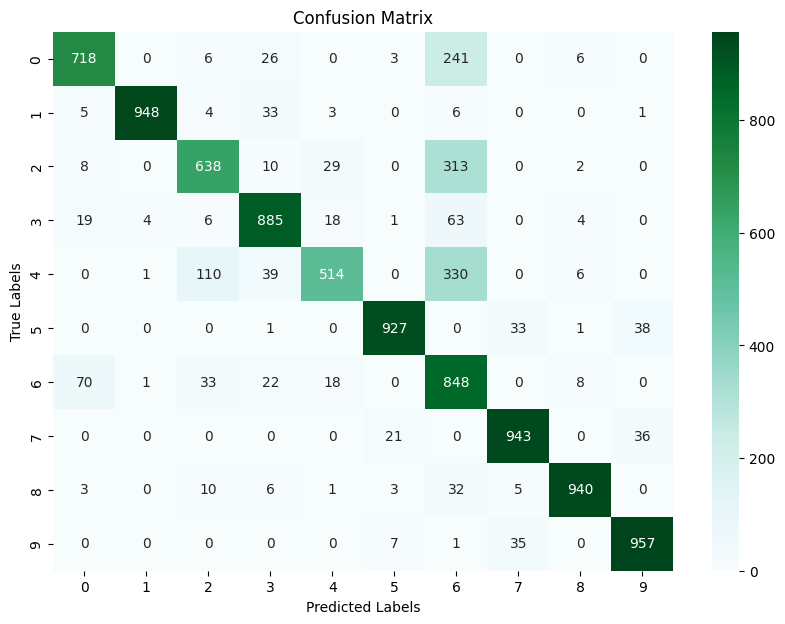

In [63]:
y_predict = better_model.predict(x_test)
# print(y_predict[508])
true_labels = np.argmax(y_test_encode, axis=1)
# print(true_labels[508])

# confusion matrix
conf_matrix = confusion_matrix(true_labels, y_predict)

print("Confusion Matrix:")
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="BuGn", cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ***Question 8***
    In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

In [109]:
def squared_error_loss(y_hat, y, sum_norm, regpara):
    m = y.shape[0]
    squared_errors = np.sum((y_hat - y) ** 2) / m
    loss = squared_errors + regpara / 2 * sum_norm
    return loss

In [136]:
class NeuralNetwork:
    #initialize the network with construtor
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)

    #initializing function
    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            # "xavier" weight_initialization
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            #random initialization
            else:
                stddev = 0.1  # standard deviation for random initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases

    #forward propagation
    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

#ref:: https://medium.com/hackernoon/building-a-feedforward-neural-network-from-scratch-in-python-d3526457156b

In [138]:
# for backward propagation and the optimizers
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of squared-error w.r.t softmax function
        da = (y_hat - y) / y.shape[0]

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad
    #ref:: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad

    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = squared_error_loss(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)

In [139]:
# highest accuracy:  -ac_tanh-hs_64-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_rmsprop-batch_32-wght_random
layer_sizes = [784, 64,64,64,64,64, 10]

# # initializing the model
# model_forward = NeuralNetwork(layer_sizes, activation_func="tanh", weight_init="random")
# a,h,y_hat = model_forward.feedforward(x_train)

better_model_sq = backward_optimizer(layer_sizes, "tanh", "random")
better_model_sq.train("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 32,regpara = 0.0005)

End of Epoch 0, Loss: 0.40398408139238556, Accuracy: 0.7139814814814814
End of Epoch 0, Validation Loss: 0.41460666422744274, Validation Accuracy: 0.7033333333333334
End of Epoch 1, Loss: 0.38958340430835847, Accuracy: 0.7279444444444444
End of Epoch 1, Validation Loss: 0.401741526132012, Validation Accuracy: 0.7185
End of Epoch 2, Loss: 0.3790405842230169, Accuracy: 0.7377592592592592
End of Epoch 2, Validation Loss: 0.39098102977057564, Validation Accuracy: 0.729
End of Epoch 3, Loss: 0.37448030440725816, Accuracy: 0.7399259259259259
End of Epoch 3, Validation Loss: 0.38620796073796837, Validation Accuracy: 0.7311666666666666
End of Epoch 4, Loss: 0.3706700009765936, Accuracy: 0.742462962962963
End of Epoch 4, Validation Loss: 0.38237593980772, Validation Accuracy: 0.7341666666666666
End of Epoch 5, Loss: 0.36957286349945423, Accuracy: 0.7428518518518519
End of Epoch 5, Validation Loss: 0.3815310165750278, Validation Accuracy: 0.7313333333333333
End of Epoch 6, Loss: 0.36640334710824

# ***Question 10***
Based on learnings above, I have to give 3 recommendations for what would work for the MNIST dataset (not Fashion-MNIST).

    Just to be clear, I am asking you to take your learnings based on extensive experimentation with one dataset and see if these learnings help on another dataset. If I give you a budget of running only 3 hyperparameter configurations as opposed to the large number of experiments you have run above then which 3 would you use and why. Report the accuracies that you obtain using these 3 configurations.

In [40]:
# importing dataset
from keras.datasets import mnist

In [42]:
# loading the data
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# spliting data for validation
x_val_mnist = x_train_mnist[54000:]
y_val_mnist = y_train_mnist[54000:]

# spliting data for training
x_train_mnist = x_train_mnist[:54000]
y_train_mnist = y_train_mnist[:54000]

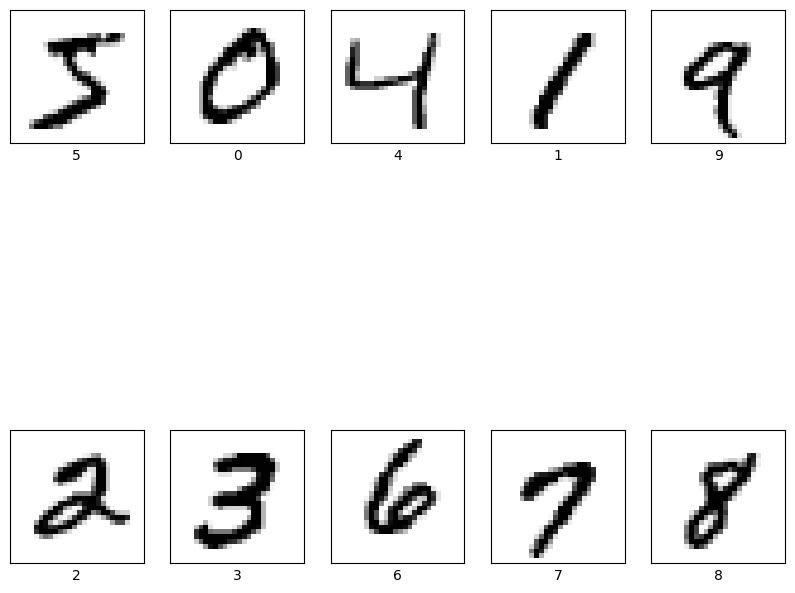

In [48]:
# labels
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']
image = []
label = []
for i in range(54000):
  if len(label) >= 10:
    break;
  if class_names[y_train_mnist[i]] not in label:
      image.append(x_train_mnist[i])
      label.append(class_names[y_train_mnist[i]])

#the dimensions of the plot grid
plt.figure(figsize=(10,10))

for i in range(len(image)):
  plt.subplot(2, 5, i+1)  #plotting in a 2x5 grid
  plt.xticks([])  #remove x-ticks
  plt.yticks([])  #remove y-ticks
  plt.grid(False)  #no grid
  plt.imshow(image[i], cmap=plt.cm.binary)  #plotting the image in binary colormap
  plt.xlabel(label[i])  #x-axis label
plt.show()

In [49]:
# vectorise the data
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 784)
# print(x_train.shape)
x_val_mnist  = x_val_mnist.reshape(x_val_mnist.shape[0], 784)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 784)

# normalize
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0
x_val_mnist  = x_val_mnist / 255.0
# print(x_train)

# One hot encoding for labels
def one_hot_enc(labels, dimension=10):
    # Creating an array of zeros of shape (number of labels, number of categories)
    one_hot_labels = np.zeros((len(labels), dimension))

    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels
#ref : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html



print(y_train_mnist[1023])
# one-hot encoding to the datasets
y_train_encode_mnist = one_hot_enc(y_train_mnist)
y_val_encode_mnist = one_hot_enc(y_val_mnist)
y_test_encode_mnist = one_hot_enc(y_test_mnist)

print(y_train_encode_mnist[1023])  # for verifying
print(y_train_encode_mnist.shape) #verifying

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(54000, 10)


In [50]:
class NeuralNetwork_mnist:
    #initialize the network with construtor
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)
        self.momenta_weights, self.momenta_biases = self.init_momenta_for_mgd()

    #initializing function
    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            # "xavier" weight_initialization
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            #random initialization
            else:
                stddev = 0.1  # standard deviation for random initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases

    #initializing momentums for mgd
    def init_momenta_for_mgd(self):
        momenta_weights = []
        momenta_biases = []
        for i in range(len(self.layer_sizes) - 1):
            v_weight = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            v_bias = np.zeros((1, self.layer_sizes[i + 1]))
            momenta_weights.append(v_weight)
            momenta_biases.append(v_bias)
        return momenta_weights, momenta_biases

    #forward propagation
    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

#ref:: https://medium.com/hackernoon/building-a-feedforward-neural-network-from-scratch-in-python-d3526457156b

In [ ]:
layer_sizes = [784, 128, 10]

# initializing the model
model_forward_mnist = NeuralNetwork_mnist(layer_sizes, activation_func="sigmoid", weight_init="random")
_,_,y_hat = model_forward_mnist.feedforward(x_train_mnist)
print('A probability distribution over the 10 classes by feedforward NN before train:: \n',y_hat[5180])
# print(sum(y_hat[51]))
print('Corresponding labelled output:: \n',y_train_encode_mnist[5180])

A probability distribution over the 10 classes by feedforward NN before train:: 
 [0.11128688 0.09366076 0.13889323 0.13388599 0.07296209 0.07613021
 0.13558938 0.06939434 0.08086319 0.08733393]
Corresponding labelled output:: 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [55]:
# for backward propagation and the optimizers
class backward_optimizer_mnist(NeuralNetwork_mnist):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad
    #ref:: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad


    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


    #ADAM
    def adam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for Adam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # Adam updates for each layer
              for i in range(len(self.weights)):
                  # updating momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_hat_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_hat_biases / (np.sqrt(v_hat_biases) + eps)

          # print loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


    #NADAM
    def nadam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs=5, eta=0.001, batch_size=16, regpara=0, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for NAdam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # NAdam updates for each layer
              for i in range(len(self.weights)):
                  # update momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # NAG rule
                  m_bar_weights = beta1 * m_hat_weights + ((1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])) / (1 - beta1 ** (epoch + 1))
                  m_bar_biases = beta1 * m_hat_biases + ((1 - beta1) * grads["db" + str(i + 1)]) / (1 - beta1 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_bar_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_bar_biases / (np.sqrt(v_hat_biases) + eps)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")



    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train_mnist(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)
        elif optimizer == 'adam':
          self.adam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)
        elif optimizer == 'nadam':
          self.nadam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)


In [56]:
# highest accuracy 1:  -ac_tanh-hs_64-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_rmsprop-batch_32-wght_random
layer_sizes = [784, 64,64,64,64,64, 10]

better_model_mnist1 = backward_optimizer_mnist(layer_sizes, "tanh", "random")
better_model_mnist1.train_mnist("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 32,regpara = 0.0005)

End of Epoch 0, Loss: 0.5745215569218054, Accuracy: 0.8366851851851852
End of Epoch 0, Validation Loss: 0.5954499668944001, Validation Accuracy: 0.8288333333333333
End of Epoch 1, Loss: 0.5368653118961789, Accuracy: 0.842574074074074
End of Epoch 1, Validation Loss: 0.5680875499757512, Validation Accuracy: 0.834
End of Epoch 2, Loss: 0.5173630511245243, Accuracy: 0.8467777777777777
End of Epoch 2, Validation Loss: 0.5542969700277703, Validation Accuracy: 0.8405
End of Epoch 3, Loss: 0.48803221720647433, Accuracy: 0.8542592592592593
End of Epoch 3, Validation Loss: 0.5287964132484091, Validation Accuracy: 0.847
End of Epoch 4, Loss: 0.46023033206454184, Accuracy: 0.8627962962962963
End of Epoch 4, Validation Loss: 0.5038646561509235, Validation Accuracy: 0.851
End of Epoch 5, Loss: 0.45628218699681383, Accuracy: 0.8632037037037037
End of Epoch 5, Validation Loss: 0.5035695202873697, Validation Accuracy: 0.852
End of Epoch 6, Loss: 0.4432396915425215, Accuracy: 0.8674814814814815
End of 

In [58]:
# highest accuracy 2: -ac_tanh-hs_128-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_rmsprop-batch_64-wght_random
layer_sizes = [784, 128,128,128,128,128, 10]

better_model_mnist2 = backward_optimizer_mnist(layer_sizes, "tanh", "random")
better_model_mnist2.train_mnist("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 64,regpara = 0.0005)

End of Epoch 0, Loss: 0.7699558255990937, Accuracy: 0.8143888888888889
End of Epoch 0, Validation Loss: 0.7939520198570844, Validation Accuracy: 0.8113333333333334
End of Epoch 1, Loss: 0.6538400252898937, Accuracy: 0.8366111111111111
End of Epoch 1, Validation Loss: 0.6861610437486455, Validation Accuracy: 0.8263333333333334
End of Epoch 2, Loss: 0.5994201371005183, Accuracy: 0.8412777777777778
End of Epoch 2, Validation Loss: 0.6360717199007415, Validation Accuracy: 0.8288333333333333
End of Epoch 3, Loss: 0.553126870586937, Accuracy: 0.8498518518518519
End of Epoch 3, Validation Loss: 0.5920076606852136, Validation Accuracy: 0.8365
End of Epoch 4, Loss: 0.5311372882238843, Accuracy: 0.8526111111111111
End of Epoch 4, Validation Loss: 0.5732231688438753, Validation Accuracy: 0.84
End of Epoch 5, Loss: 0.49745338741304357, Accuracy: 0.8615925925925926
End of Epoch 5, Validation Loss: 0.5426118883092044, Validation Accuracy: 0.8525
End of Epoch 6, Loss: 0.4734724649530794, Accuracy: 0.

In [64]:
# highest accuracy 3: -ac_tanh-hs_128-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_rmsprop-batch_16-wght_random
layer_sizes = [784, 128,128,128,128,128, 10]

better_model_mnist2 = backward_optimizer_mnist(layer_sizes, "tanh", "random")
better_model_mnist2.train_mnist("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 16,regpara = 0.0005)

End of Epoch 0, Loss: 0.6204211286779224, Accuracy: 0.8500555555555556
End of Epoch 0, Validation Loss: 0.6453299137131663, Validation Accuracy: 0.8431666666666666
End of Epoch 1, Loss: 0.5335754107654553, Accuracy: 0.8599444444444444
End of Epoch 1, Validation Loss: 0.5605108422270155, Validation Accuracy: 0.8526666666666667
End of Epoch 2, Loss: 0.48887141036221093, Accuracy: 0.8659259259259259
End of Epoch 2, Validation Loss: 0.5164204971591294, Validation Accuracy: 0.8578333333333333
End of Epoch 3, Loss: 0.47465031490970716, Accuracy: 0.8666666666666667
End of Epoch 3, Validation Loss: 0.5049781710692715, Validation Accuracy: 0.8561666666666666
End of Epoch 4, Loss: 0.4672628346083284, Accuracy: 0.8673703703703703
End of Epoch 4, Validation Loss: 0.502686226855026, Validation Accuracy: 0.8566666666666667
End of Epoch 5, Loss: 0.4659810117696959, Accuracy: 0.8668148148148148
End of Epoch 5, Validation Loss: 0.49988884323871946, Validation Accuracy: 0.8608333333333333
End of Epoch 6